In [ ]:
# Import necessary modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.cluster import KMeans

from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, confusion_matrix, mean_squared_error, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, f1_score, log_loss, recall_score, precision_score
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
np.random.seed(5)
import time
plt.style.use('seaborn')

# **Load the Preprocessed Data**


In [ ]:
df = pd.read_csv('processed_online_shoppers_intention.csv')

In [ ]:
# Check the shape of dataset

print(df.shape)

(12330, 21)


In [ ]:
# Information of data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  OperatingSystems         12330 non-null  int64  
 11  Browser                  12330 non-null  int64  
 12  Region                   12330 non-null  int64  
 13  TrafficType              12330 non-null  int64  
 14  Weekend               

In [ ]:
# print data

df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,Month_sin,Month_cos,New_Visitor,Other,Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,1,1,1,1,0,0,0.5,0.866025,0.0,0.0,1.0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,1,2,0,0,0.5,0.866025,0.0,0.0,1.0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,4,1,9,3,0,0,0.5,0.866025,0.0,0.0,1.0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,3,2,2,4,0,0,0.5,0.866025,0.0,0.0,1.0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,3,3,1,4,1,0,0.5,0.866025,0.0,0.0,1.0


In [ ]:
# Separate the test dataset into target label and feature variables

X = df.drop('Revenue', axis = 1)
y = df['Revenue']

In [ ]:
X.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Month_sin,Month_cos,New_Visitor,Other,Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,1,1,1,1,0,0.5,0.866025,0.0,0.0,1.0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,1,2,0,0.5,0.866025,0.0,0.0,1.0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,4,1,9,3,0,0.5,0.866025,0.0,0.0,1.0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,3,2,2,4,0,0.5,0.866025,0.0,0.0,1.0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,3,3,1,4,1,0.5,0.866025,0.0,0.0,1.0


## Normalize Data

In [ ]:
X_normalized = Normalizer().fit_transform(X)
X = pd.DataFrame(X_normalized,columns=X.columns)

In [ ]:
X.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Month_sin,Month_cos,New_Visitor,Other,Returning_Visitor
0,0.0,0.0,0.0,0.0,0.375823,0.000000,0.075165,0.075165,0.0,0.0,0.375823,0.375823,0.375823,0.375823,0.000000,0.187912,0.325472,0.0,0.0,0.375823
1,0.0,0.0,0.0,0.0,0.031178,0.997687,0.000000,0.001559,0.0,0.0,0.031178,0.031178,0.015589,0.031178,0.000000,0.007794,0.013500,0.0,0.0,0.015589
2,0.0,0.0,0.0,0.0,0.095312,0.000000,0.019062,0.019062,0.0,0.0,0.381246,0.095312,0.857804,0.285935,0.000000,0.047656,0.082542,0.0,0.0,0.095312
3,0.0,0.0,0.0,0.0,0.294458,0.392610,0.007361,0.020612,0.0,0.0,0.441687,0.294458,0.294458,0.588916,0.000000,0.073614,0.127504,0.0,0.0,0.147229
4,0.0,0.0,0.0,0.0,0.015933,0.999825,0.000032,0.000080,0.0,0.0,0.004780,0.004780,0.001593,0.006373,0.001593,0.000797,0.001380,0.0,0.0,0.001593


# **Feature Selection**

### Recursive Feature Elimination

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  "X does not have valid feature names, but"


The optimal number of features is 19
The selected features are:
['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend', 'Month_sin', 'Month_cos', 'New_Visitor', 'Returning_Visitor']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


CPU times: user 1min 42s, sys: 225 ms, total: 1min 42s
Wall time: 1min 42s


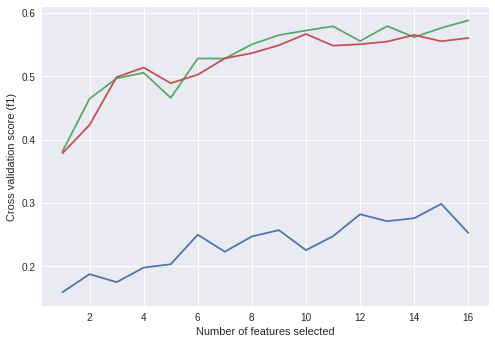

In [ ]:
%%time
from sklearn.feature_selection import RFECV

rfc_model = RandomForestClassifier()

selector = RFECV(estimator=rfc_model, min_features_to_select=5, cv=3, scoring="f1")
selector.fit(X, y)

print('The optimal number of features is {}'.format(selector.n_features_))
features = [f for f,s in zip(X.columns, selector.support_) if s]
print('The selected features are:')
print ('{}'.format(features))

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (f1)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.savefig('feature_auc_nselected.png', bbox_inches='tight', pad_inches=1)


In [ ]:
# selected_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 19]
selected_features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend', 'Month_sin', 'Month_cos', 'New_Visitor', 'Returning_Visitor']

In [ ]:
X = X[selected_features]

# **Machine Learning Models**

### Split the data into Train, Test and Unlabelled data

In [ ]:
df = pd.concat([X, y], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  float64
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  float64
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  float64
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  OperatingSystems         12330 non-null  float64
 11  Browser                  12330 non-null  float64
 12  Region                   12330 non-null  float64
 13  TrafficType              12330 non-null  float64
 14  Weekend               

In [ ]:
# Assign data to train, test, and unlabeled sets

def reset_holdout_splits(X,y, unlabelled_size,holdout_test_size=0.2): 

  X_holdout, X_unlabelled, y_holdout, y_unlabelled = train_test_split(X, y, 
                                                                     test_size=unlabelled_size, random_state=1, stratify=y)

  X_train, X_test, y_train, y_test = train_test_split(X_holdout, y_holdout, test_size=holdout_test_size,
                                                      random_state=1, stratify=y_holdout)

  return X_train, y_train, X_test, y_test, X_unlabelled


### Self-Training Function

In [ ]:
def selfTraining(clf, X_train, y_train, X_unlabelled, X_test, y_test, confidence_score, auto_balancing=False): 
    # Initiate iteration counter
    iterations = 0

    # Containers to hold f1_scores and # of pseudo-labels
    test_accuracy = []
    train_f1s = []
    test_f1s = []
    pseudo_labels = []

    # Assign value to initiate while loop
    high_prob = [1]

    # Loop will run until there are no more high-probability pseudo-labels
    while len(high_prob) > 0:
            
        # Fit classifier and make train/test predictions
        clf.fit(X_train, y_train)
        y_hat_train = clf.predict(X_train)
        y_hat_test = clf.predict(X_test)

        # Calculate and print iteration # and f1 scores, and store f1 scores
        test_acc = accuracy_score(y_test, y_hat_test)
        train_f1 = f1_score(y_train, y_hat_train)
        test_f1 = f1_score(y_test, y_hat_test)
        print(f"Iteration {iterations}")
        print(f"Test Accuracy: {test_acc}")
        print(f"Train f1: {train_f1}")
        print(f"Test f1: {test_f1}")
        train_f1s.append(train_f1)
        test_f1s.append(test_f1)
        test_accuracy.append(test_acc)
    
        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs = clf.predict_proba(X_unlabelled)
        preds = clf.predict(X_unlabelled)
        prob_0 = pred_probs[:,0]
        prob_1 = pred_probs[:,1]

        # Store predictions and probabilities in dataframe
        df_pred_prob = pd.DataFrame([])
        df_pred_prob['preds'] = preds
        df_pred_prob['prob_0'] = prob_0
        df_pred_prob['prob_1'] = prob_1
        df_pred_prob.index = X_unlabelled.index
        
        # Separate predictions with > 99% probability
        high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > confidence_score],
                            df_pred_prob.loc[df_pred_prob['prob_1'] > confidence_score]],
                            axis=0)
        
        print(f"{len(high_prob)} high-probability predictions added to training data.")
        
        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train = pd.concat([X_train, X_unlabelled.loc[high_prob.index]], axis=0)
        y_train = pd.concat([y_train, high_prob.preds])      
        
        if auto_balancing:
          merged_df = pd.concat([X_train, y_train], axis=1)
          zero_count = len(y_train[y_train == 0])
          one_count = len(y_train[y_train == 1])

          is_balanced_data = False
          if zero_count == one_count:
            is_balanced_data = True
          if not(is_balanced_data):
            sampler = SMOTE(sampling_strategy=1)
            X_train, y_train = sampler.fit_resample(X_train, y_train)

        # Drop pseudo-labeled instances from unlabeled data
        X_unlabelled = X_unlabelled.drop(index=high_prob.index)
        print(f"{len(X_unlabelled)} unlabeled instances remaining.\n")
        
        # Update iteration counter
        iterations += 1

    fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test, y_hat_test)
    roc_auc_clf = auc(fpr_clf, tpr_clf)

    roc_auc_params = [fpr_clf, tpr_clf, roc_auc_clf]
    return test_accuracy, test_f1s, roc_auc_params

### Co-Training Function

In [ ]:
def coTraining(clf1, clf2, view1, view2, X_train, y_train, X_unlabelled, X_test, y_test, confidence_score, auto_balancing=False):
    # Initiate iteration counter
    iterations = 0

    # Containers to hold f1_scores and # of pseudo-labels
    test_accuracy = {0: [], 1:[]}

    train_f1s = {0: [],1: []}

    test_f1s = {0: [],1: []}

    pseudo_labels = []

    # Assign value to initiate while loop
    high_prob = [1]

    # cotraining classifiers 
    clfs = [clf1, clf2]
    # Loop will run until there are no more high-probability pseudo-labels
    while len(high_prob) > 0:
        
        # Fit classifier and make train/test predictions
        for i in [0,1]: 

            clf = clfs[i]

            if i == 0:
                X_train = X_train[view1]
                X_test = X_test[view1]
                X_unlabelled = X_unlabelled[view1]
            else: 
                X_train = X_train[view2]
                X_test = X_test[view2]
                X_unlabelled = X_unlabelled[view2]
            
            clf.fit(X_train, y_train)

            y_hat_train = clf.predict(X_train)
            y_hat_test = clf.predict(X_test)

            # Calculate and print iteration # and f1 scores, and store f1 scores
            test_acc = accuracy_score(y_test, y_hat_test)
            train_f1 = f1_score(y_train, y_hat_train)
            test_f1 = f1_score(y_test, y_hat_test)
            print(f"Iteration {iterations}, Classifier: {i}")
            print(f"Clf: {i}: Test Accuracy: {test_acc}")
            print(f"Clf: {i}: Train f1: {train_f1}")
            print(f"Clf: {i}: Test f1: {test_f1}")
            test_accuracy[i].append(test_acc)
            train_f1s[i].append(train_f1)
            test_f1s[i].append(test_f1)
            
            # Generate predictions and probabilities for unlabeled data
            print(f"Now predicting labels for unlabeled data...")

            pred_probs = clf.predict_proba(X_unlabelled)
            preds = clf.predict(X_unlabelled)
            prob_0 = pred_probs[:,0]
            prob_1 = pred_probs[:,1]

            # Store predictions and probabilities in dataframe
            df_pred_prob = pd.DataFrame([])
            df_pred_prob['preds'] = preds
            df_pred_prob['prob_0'] = prob_0
            df_pred_prob['prob_1'] = prob_1
            df_pred_prob.index = X_unlabelled.index
            
            # Separate predictions with > 99% probability
            high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > confidence_score],
                                    df_pred_prob.loc[df_pred_prob['prob_1'] > confidence_score]],
                                    axis=0)
            
            print(f"{len(high_prob)} high-probability predictions added to training data.")
            
            pseudo_labels.append(len(high_prob))

            # Add pseudo-labeled data to training data
            X_train = pd.concat([X_train, X_unlabelled.loc[high_prob.index]], axis=0)
            y_train = pd.concat([y_train, high_prob.preds])  

            if auto_balancing:
              merged_df = pd.concat([X_train, y_train], axis=1)
              zero_count = len(y_train[y_train == 0])
              one_count = len(y_train[y_train == 1])

              is_balanced_data = False
              if zero_count == one_count:
                is_balanced_data = True
                
              if not(is_balanced_data):
                sampler = SMOTE(sampling_strategy=1)
                X_train, y_train = sampler.fit_resample(X_train, y_train)
            
            # Drop pseudo-labeled instances from unlabeled data
            X_unlabelled = X_unlabelled.drop(index=high_prob.index)
            print(f"{len(X_unlabelled)} unlabeled instances remaining.\n")
            
            if (len(high_prob) == 0):
              break
            # Update iteration counter
            iterations += 1

    fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test, y_hat_test)
    roc_auc_clf = auc(fpr_clf, tpr_clf)

    roc_auc_params = [fpr_clf, tpr_clf, roc_auc_clf]
    return test_accuracy, test_f1s, roc_auc_params

### Boosting function (Assemble)

In [ ]:
def boosting_assemble(clf, X_train, y_train, X_unlabelled, X_test, y_test, margin, auto_balancing=False): 
    # Initiate iteration counter
    iterations = 0

    # Containers to hold f1_scores and # of pseudo-labels
    test_accuracy = []
    train_f1s = []
    test_f1s = []
    pseudo_labels = []

    # Assign value to initiate while loop
    high_prob = [1]

    # Loop will run until there are no more high-probability pseudo-labels
    while len(high_prob) > 0:
            
        # Fit classifier and make train/test predictions
        clf = clf.fit(X_train,y_train)
        
        y_hat_train = clf.predict(X_train)
        y_hat_test = clf.predict(X_test)

        # Calculate and print iteration # and f1 scores, and store f1 scores
        test_acc = accuracy_score(y_test, y_hat_test)
        train_f1 = f1_score(y_train, y_hat_train)
        test_f1 = f1_score(y_test, y_hat_test)
        print(f"Iteration {iterations}")
        print(f"Test Accuracy: {test_acc}")
        print(f"Train f1: {train_f1}")
        print(f"Test f1: {test_f1}")
        test_accuracy.append(test_acc)
        train_f1s.append(train_f1)
        test_f1s.append(test_f1)
    
        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs = clf.predict_proba(X_unlabelled)
        preds = clf.predict(X_unlabelled)
        prob_0 = pred_probs[:,0]
        prob_1 = pred_probs[:,1]

        # Store predictions and probabilities in dataframe
        df_pred_prob = pd.DataFrame([])
        df_pred_prob['preds'] = preds
        df_pred_prob['prob_0'] = prob_0
        df_pred_prob['prob_1'] = prob_1
        df_pred_prob.index = X_unlabelled.index
        
        # Separate predictions with > 99% probability
        high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > margin],
                            df_pred_prob.loc[df_pred_prob['prob_1'] > margin]],
                            axis=0)
        
        print(f"{len(high_prob)} high-probability predictions added to training data.")
        
        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train =  pd.concat([X_train, X_unlabelled.loc[high_prob.index]], axis=0)
        y_train = pd.concat([y_train, high_prob.preds]) 
        
        if auto_balancing:
          merged_df = pd.concat([X_train, y_train], axis=1)
          zero_count = len(y_train[y_train == 0])
          one_count = len(y_train[y_train == 1])

          is_balanced_data = False
          if zero_count == one_count:
            is_balanced_data = True
        
          if not(is_balanced_data):
            sampler = SMOTE(sampling_strategy=1)
            X_train, y_train = sampler.fit_resample(X_train, y_train)

        # Drop pseudo-labeled instances from unlabeled data
        X_unlabelled = X_unlabelled.drop(index=high_prob.index)
        print(f"{len(X_unlabelled)} unlabeled instances remaining.\n")
        
        # Update iteration counter
        iterations += 1

    fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test, y_hat_test)
    roc_auc_clf = auc(fpr_clf, tpr_clf)

    roc_auc_params = [fpr_clf, tpr_clf, roc_auc_clf]
    return test_accuracy, test_f1s, roc_auc_params

### Unsupervised Clustering/Pre-processing function

In [ ]:
def unsupervised_labelling (clf, X_train, y_train, X_unlabelled, X_test, y_test, confidence_score, auto_balancing=False): 
    iterations = 0

    # Containers to hold f1_scores and # of pseudo-labels
    test_accuracy = []
    train_f1s = []
    test_f1s = []
    pseudo_labels = []

    # Assign value to initiate while loop
    high_prob = [1]

    # print(f"{X_train.shape} {X_test.shape} {y_train.shape} {y_test.shape}")
    X_combined = pd.concat([X_train, X_test])
    y_combined = pd.concat([y_train, y_test])
    y_combined.reset_index(drop=True, inplace=True)

    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X_combined)

    X_new_feature = kmeans.labels_
    X_new_feature = pd.DataFrame(X_new_feature,columns=['cluster'])

    X_combined.reset_index(drop=True,inplace=True)
    X_new_feature.reset_index(drop=True,inplace=True)

    X_new = pd.concat([X_combined, X_new_feature],axis=1)

    Unlabelled_new_feature = kmeans.predict(X_unlabelled)
    Unlabelled_new_feature = pd.DataFrame(Unlabelled_new_feature, columns=['cluster'])
    X_unlabelled.reset_index(drop=True,inplace=True)
    Unlabelled_new_feature.reset_index(drop=True,inplace=True)

    X_unlabelled = pd.concat([X_unlabelled, Unlabelled_new_feature],axis=1)

    print(f"{X_new.shape} {y_combined.shape}")
    X_train, X_test, y_train, y_test = train_test_split(X_new, y_combined, test_size=0.1, stratify=y_combined)

    # Loop will run until there are no more high-probability pseudo-labels
    while len(high_prob) > 0:
        clf.fit(X_train, y_train)
        y_hat_train = clf.predict(X_train)
        y_hat_test = clf.predict(X_test)

        # Calculate and print iteration # and f1 scores, and store f1 scores
        test_acc = accuracy_score(y_test, y_hat_test)
        train_f1 = f1_score(y_train, y_hat_train)
        test_f1 = f1_score(y_test, y_hat_test)
        print(f"Iteration {iterations}")
        print(f"Test Accuracy: {test_acc}")
        print(f"Train f1: {train_f1}")
        print(f"Test f1: {test_f1}")
        train_f1s.append(train_f1)
        test_f1s.append(test_f1)
        test_accuracy.append(test_acc)

        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs = clf.predict_proba(X_unlabelled)
        preds = clf.predict(X_unlabelled)
        prob_0 = pred_probs[:,0]
        prob_1 = pred_probs[:,1]

        # Store predictions and probabilities in dataframe
        df_pred_prob = pd.DataFrame([])
        df_pred_prob['preds'] = preds
        df_pred_prob['prob_0'] = prob_0
        df_pred_prob['prob_1'] = prob_1
        df_pred_prob.index = X_unlabelled.index
        
        # Separate predictions with > 99% probability
        high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > confidence_score],
                            df_pred_prob.loc[df_pred_prob['prob_1'] > confidence_score]],
                            axis=0)
        
        print(f"{len(high_prob)} high-probability predictions added to training data.")
        
        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train = pd.concat([X_train, X_unlabelled.loc[high_prob.index]], axis=0)
        y_train = pd.concat([y_train, high_prob.preds])      
        
        if auto_balancing:
          print("doing balancing")
          merged_df = pd.concat([X_train, y_train], axis=1)
          zero_count = len(y_train[y_train == 0])
          one_count = len(y_train[y_train == 1])

          is_balanced_data = False
          if zero_count == one_count:
            is_balanced_data = True
          
          if not(is_balanced_data):
            print("applying smote")
            sampler = SMOTE(sampling_strategy=1)
            X_train, y_train = sampler.fit_resample(X_train, y_train)

        # Drop pseudo-labeled instances from unlabeled data
        X_unlabelled = X_unlabelled.drop(index=high_prob.index)
        print(f"{len(X_unlabelled)} unlabeled instances remaining.\n")
        
        # Update iteration counter
        iterations += 1

    fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test, y_hat_test)
    roc_auc_clf = auc(fpr_clf, tpr_clf)

    roc_auc_params = [fpr_clf, tpr_clf, roc_auc_clf]
    return test_accuracy, test_f1s, roc_auc_params

# 1. 100% labelled data - Fully Supervised learning - Imbalanced

### Random Forest - Imbalanced

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

AxesSubplot(0.125,0.125;0.775x0.755)


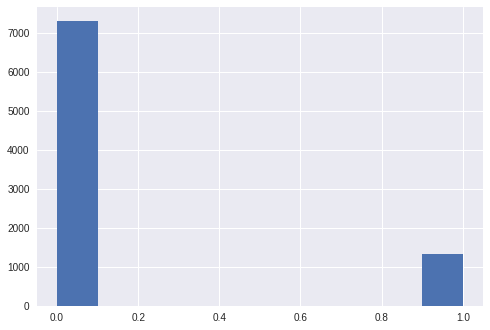

In [ ]:
print(y_train.hist())

In [ ]:
# Random Forest Classifier for Binary classification
%%time
param_grid = {'n_estimators':[22,33,111,251],
              'min_samples_split': [2,3,4,5,6],
              'min_samples_leaf': [1,2,3,4],
              'max_depth': [5, 7, 9],
              'n_jobs': [-1]}

# Random Forest Classifier
rfc = RandomForestClassifier()
grid_rfc = GridSearchCV(rfc, param_grid, scoring="f1", cv=5, return_train_score=False)
grid_rfc.fit(X_train, y_train)
pred_rfc = grid_rfc.predict(X_test)

# calculate and display our base accuracy
acc_score = accuracy_score(y_test, pred_rfc)
rfc_score = f1_score (y_test, pred_rfc)
print("Accuracy-Score: %s" % acc_score)
print("F1-Score: %s" % rfc_score)

# print classification report 
print(classification_report(y_test, pred_rfc))

Accuracy-Score: 0.901595025682617
F1-Score: 0.6231884057971016
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3127
           1       0.76      0.53      0.62       572

    accuracy                           0.90      3699
   macro avg       0.84      0.75      0.78      3699
weighted avg       0.89      0.90      0.89      3699



In [ ]:
print(grid_rfc.best_params_)

{'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 111, 'n_jobs': -1}


In [ ]:
%%time
# {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 111, 'n_jobs': -1}
rfc = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

# calculate and display our base accuracy
rfc_f1_score = f1_score(y_test, pred_rfc)
rfc_acc_score = accuracy_score(y_test, pred_rfc)
print("F1-Score: %s" % rfc_f1_score)

print("Accuracy-Score: %s" % rfc_acc_score)

# print classification report 
print(classification_report(y_test, pred_rfc))

F1-Score: 0.640495867768595
Accuracy-Score: 0.9059205190592052
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      3127
           1       0.78      0.54      0.64       572

    accuracy                           0.91      3699
   macro avg       0.85      0.76      0.79      3699
weighted avg       0.90      0.91      0.90      3699

CPU times: user 2.62 s, sys: 24.8 ms, total: 2.64 s
Wall time: 1.57 s


In [ ]:
fpr_imb, tpr_imb, thresholds_imb = roc_curve(y_test, pred_rfc)
roc_auc_imb = auc(fpr_imb, tpr_imb)

### Random Forest - Balanced

In [ ]:
smt = SMOTE(sampling_strategy=0.75)
X_train_sampled, y_train_sampled = smt.fit_resample(X_train, y_train)
np.bincount(y_train_sampled)

array([7295, 5471])

In [ ]:
X_train_sampled = pd.DataFrame(X_train_sampled)
y_train_sampled = pd.DataFrame(y_train_sampled)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feff72c5110>]],
      dtype=object)

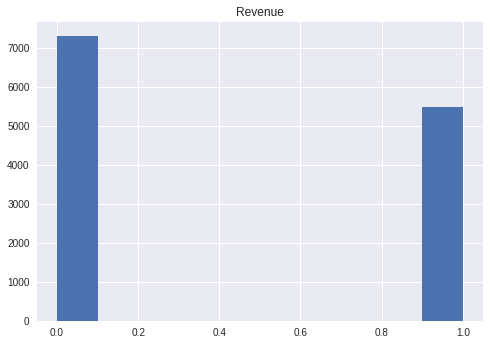

In [ ]:
y_train_sampled.hist()

In [ ]:
y_train_temp = y_train_sampled.values
y_train_sampled = np.ravel(y_train_temp)
y_train_sampled.shape

(12766,)

In [ ]:
%%time
rfc = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
rfc.fit(X_train_sampled, y_train_sampled)
pred_rfc = rfc.predict(X_test)

# calculate and display our base accuracy
rfc_f1_score = f1_score(y_test, pred_rfc)
rfc_acc_score = accuracy_score(y_test, pred_rfc)
print("F1-Score: %s" % rfc_f1_score)
print("Accuracy Score: %s"%rfc_acc_score)

# print classification report 
print(classification_report(y_test, pred_rfc))

F1-Score: 0.675092936802974
Accuracy Score: 0.881859962151933
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      3127
           1       0.59      0.79      0.68       572

    accuracy                           0.88      3699
   macro avg       0.77      0.85      0.80      3699
weighted avg       0.90      0.88      0.89      3699

CPU times: user 4.02 s, sys: 17.2 ms, total: 4.04 s
Wall time: 2.28 s


In [ ]:
fpr_bal, tpr_bal, thresholds_bal = roc_curve(y_test, pred_rfc)
roc_auc_bal = auc(fpr_bal, tpr_bal)

# 2. 10% unlabelled, 90% labelled data 

### Self Training - Imbalanced

In [ ]:
%%time 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
st_acc_10_imb, st_f1_10_imb, st_10_imb_roc = selfTraining(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score)

Iteration 0
Test Accuracy: 0.9004504504504505
Train f1: 0.7510692899914456
Test f1: 0.6169844020797227
Now predicting labels for unlabeled data...
566 high-probability predictions added to training data.
667 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9027027027027027
Train f1: 0.7600671140939598
Test f1: 0.6338983050847458
Now predicting labels for unlabeled data...
53 high-probability predictions added to training data.
614 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9045045045045045
Train f1: 0.7576013513513513
Test f1: 0.636986301369863
Now predicting labels for unlabeled data...
32 high-probability predictions added to training data.
582 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.9036036036036036
Train f1: 0.7556120288013554
Test f1: 0.629757785467128
Now predicting labels for unlabeled data...
7 high-probability predictions added to training data.
575 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.9031531531531531


### Self Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
st_acc_10_bal, st_f1_10_bal, st_10_bal_roc = selfTraining(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score, auto_balancing=True)

Iteration 0
Test Accuracy: 0.9027027027027027
Train f1: 0.7433930093776642
Test f1: 0.6275862068965516
Now predicting labels for unlabeled data...
580 high-probability predictions added to training data.
653 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8806306306306306
Train f1: 0.9187946266489168
Test f1: 0.6818727490996399
Now predicting labels for unlabeled data...
9 high-probability predictions added to training data.
644 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.881981981981982
Train f1: 0.9188405797101449
Test f1: 0.6850961538461539
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
643 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.881981981981982
Train f1: 0.9179199130277224
Test f1: 0.6843373493975904
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
642 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8815315315315315
Tr

### Co-Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)

view1 = selected_features
view2 = selected_features

confidence_score = 0.95

ct_acc_10_imb, ct_f1_10_imb, ct_10_imb_roc = coTraining(clf1, clf2, view1, view2, X_train,
                                                       y_train, X_unlabelled, X_test, y_test, confidence_score)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8837837837837837
Clf: 0: Train f1: 0.4352879027997887
Clf: 0: Test f1: 0.4579831932773109
Now predicting labels for unlabeled data...
80 high-probability predictions added to training data.
1153 unlabeled instances remaining.

Iteration 1, Classifier: 1
Clf: 1: Test Accuracy: 0.9013513513513514
Clf: 1: Train f1: 0.7576257213520199
Clf: 1: Test f1: 0.6256410256410257
Now predicting labels for unlabeled data...
534 high-probability predictions added to training data.
619 unlabeled instances remaining.

Iteration 2, Classifier: 0
Clf: 0: Test Accuracy: 0.8837837837837837
Clf: 0: Train f1: 0.45038560411311057
Clf: 0: Test f1: 0.4579831932773109
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
618 unlabeled instances remaining.

Iteration 3, Classifier: 1
Clf: 1: Test Accuracy: 0.9022522522522523
Clf: 1: Train f1: 0.7584480600750938
Clf: 1: Test f1: 0.617283950617284
Now predicting labels f

### Co-Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)

view1 = selected_features
view2 = selected_features

confidence_score = 0.95

ct_acc_10_bal, ct_f1_10_bal, ct_10_bal_roc = coTraining(clf1, clf2, view1, view2, X_train, y_train, 
                                                       X_unlabelled, X_test, y_test, confidence_score,
                                                       auto_balancing=True)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8837837837837837
Clf: 0: Train f1: 0.4352879027997887
Clf: 0: Test f1: 0.4579831932773109
Now predicting labels for unlabeled data...
80 high-probability predictions added to training data.
1153 unlabeled instances remaining.

Iteration 1, Classifier: 1
Clf: 1: Test Accuracy: 0.8801801801801802
Clf: 1: Train f1: 0.9144808919249856
Clf: 1: Test f1: 0.6818181818181819
Now predicting labels for unlabeled data...
253 high-probability predictions added to training data.
900 unlabeled instances remaining.

Iteration 2, Classifier: 0
Clf: 0: Test Accuracy: 0.8734234234234234
Clf: 0: Train f1: 0.742705178399941
Clf: 0: Test f1: 0.6113416320885201
Now predicting labels for unlabeled data...
55 high-probability predictions added to training data.
845 unlabeled instances remaining.

Iteration 3, Classifier: 1
Clf: 1: Test Accuracy: 0.8810810810810811
Clf: 1: Train f1: 0.9181264753385513
Clf: 1: Test f1: 0.6842105263157895
Now predicting labels f

### Semi-Supervised Ensemble - Imbalanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_10_imb, sse_f1_10_imb, sse_10_imb_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=False)


Iteration 0
Test Accuracy: 0.9049549549549549
Train f1: 0.6946011281224819
Test f1: 0.6569105691056911
Now predicting labels for unlabeled data...
679 high-probability predictions added to training data.
554 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9063063063063063
Train f1: 0.6934393638170974
Test f1: 0.6623376623376623
Now predicting labels for unlabeled data...
30 high-probability predictions added to training data.
524 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9081081081081082
Train f1: 0.6976929196499603
Test f1: 0.6677524429967426
Now predicting labels for unlabeled data...
11 high-probability predictions added to training data.
513 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.9054054054054054
Train f1: 0.7013502779984113
Test f1: 0.6601941747572815
Now predicting labels for unlabeled data...
6 high-probability predictions added to training data.
507 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.904954954954954

### Semi-Supervised Ensemble - Balanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_10_bal, sse_f1_10_bal, sse_10_bal_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=True)


Iteration 0
Test Accuracy: 0.9049549549549549
Train f1: 0.6946011281224819
Test f1: 0.6569105691056911
Now predicting labels for unlabeled data...
679 high-probability predictions added to training data.
554 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8855855855855855
Train f1: 0.9169175195665261
Test f1: 0.6902439024390243
Now predicting labels for unlabeled data...
20 high-probability predictions added to training data.
534 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8828828828828829
Train f1: 0.9148757353823989
Test f1: 0.6844660194174756
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
533 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8842342342342342
Train f1: 0.9148757353823989
Test f1: 0.6869671132764921
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
533 unlabeled instances remaining.

CPU times: user 10.9 s, sys: 880 ms, total: 1

### Unsupervised labelling - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.1, holdout_test_size=0.2)


clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
usl_acc_10_imb, usl_f1_10_imb, usl_10_imb_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=False)

(11097, 20) (11097,)
Iteration 0
Test Accuracy: 0.9081081081081082
Train f1: 0.7441154138192863
Test f1: 0.6530612244897959
Now predicting labels for unlabeled data...
594 high-probability predictions added to training data.
639 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9036036036036036
Train f1: 0.7482837528604119
Test f1: 0.6372881355932203
Now predicting labels for unlabeled data...
22 high-probability predictions added to training data.
617 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9018018018018018
Train f1: 0.7532857679309052
Test f1: 0.6254295532646049
Now predicting labels for unlabeled data...
27 high-probability predictions added to training data.
590 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.9072072072072072
Train f1: 0.7481203007518799
Test f1: 0.6531986531986532
Now predicting labels for unlabeled data...
20 high-probability predictions added to training data.
570 unlabeled instances remaining.

Iteration 4
Test Accur

### Unsupervised labelling - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.1, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
usl_acc_10_bal, usl_f1_10_bal, usl_10_bal_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=True)

(11097, 20) (11097,)
Iteration 0
Test Accuracy: 0.8990990990990991
Train f1: 0.7442387608613523
Test f1: 0.6164383561643836
Now predicting labels for unlabeled data...
552 high-probability predictions added to training data.
doing balancing
applying smote
681 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8684684684684685
Train f1: 0.9188251869513384
Test f1: 0.6588785046728972
Now predicting labels for unlabeled data...
11 high-probability predictions added to training data.
doing balancing
applying smote
670 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8693693693693694
Train f1: 0.91990672956998
Test f1: 0.6588235294117647
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
doing balancing
applying smote
669 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8702702702702703
Train f1: 0.9193199047000216
Test f1: 0.6635514018691588
Now predicting labels for unlabeled data...
1 high-probability predi

### Intrinsic - LabelSpreading - Imbalanced

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

highly_correlated_features = ['PageValues', 'ExitRates','Administrative','ProductRelated','ProductRelated_Duration',
                     'BounceRates','Month_sin']

X_intrinsic = X[highly_correlated_features]
X_scaled_int = StandardScaler().fit_transform(X_intrinsic)
X_scaled_int = pd.DataFrame(X_scaled_int,columns=X_intrinsic.columns)

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.10, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

# create the training dataset input
X_train_mixed = np.concatenate((X_train, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train.shape, y_train.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (8877, 7) (8877,)
Unlabeled Train Set: (1233, 7) (1233,)
Test Set: (2220, 7) (2220,)
CPU times: user 15.2 ms, sys: 929 µs, total: 16.1 ms
Wall time: 16.1 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feff7a3e490>]],
      dtype=object)

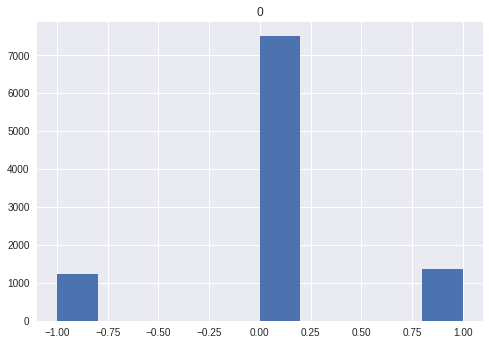

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_10_model_imb = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_10_model_imb.classes_)
print(intrinsic_10_model_imb.score(X_train_mixed, y_train_mixed))

[0 1]
0.7887240356083086
CPU times: user 517 ms, sys: 5.68 ms, total: 523 ms
Wall time: 531 ms


In [ ]:
y_pred = intrinsic_10_model_imb.predict(X_test)
print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.8945945945945946
0.6006825938566553


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
fpr_int_10_imb, tpr_int_10_imb, thresholds_int_10_imb = roc_curve(y_test, y_pred)
auc_int_10_imb = auc(fpr_int_10_imb, tpr_int_10_imb)

### Intrinsic - LabelSpreading - Balanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.10, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

under_sampler = RandomUnderSampler(random_state=12, sampling_strategy = 0.4)
X_train_undersampled, y_train_undersampled = under_sampler.fit_resample(X_train,y_train)

over_sampler = SMOTE(sampling_strategy=1.0)
X_train_sampled, y_train_sampled = over_sampler.fit_resample(X_train_undersampled, y_train_undersampled)

# create the training dataset input
X_train_mixed = np.concatenate((X_train_sampled, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train_sampled, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train_sampled.shape, y_train_sampled.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (6870, 7) (6870,)
Unlabeled Train Set: (1233, 7) (1233,)
Test Set: (2220, 7) (2220,)
CPU times: user 36.5 ms, sys: 0 ns, total: 36.5 ms
Wall time: 36.5 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feff7981450>]],
      dtype=object)

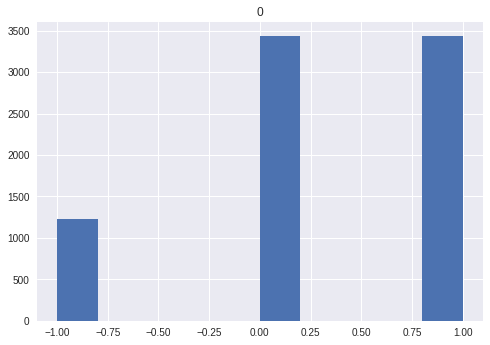

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_10_model_bal = LabelSpreading(alpha=0.1,max_iter=100, tol=0.01).fit(X_train_mixed, y_train_mixed)
print(intrinsic_10_model_bal.classes_)
print(intrinsic_10_model_bal.score(X_train_mixed, y_train_mixed))

[0 1]
0.6687646550660249
CPU times: user 5.9 s, sys: 875 ms, total: 6.78 s
Wall time: 5.48 s


In [ ]:
y_pred = intrinsic_10_model_bal.predict(X_test)

print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8891891891891892
0.6306306306306306


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [ ]:
fpr_int_10_bal, tpr_int_10_bal, thresholds_int_10_bal = roc_curve(y_test, y_pred)
auc_int_10_bal = auc(fpr_int_10_bal, tpr_int_10_bal)

# 3. 20% unlabelled, 80% labelled data 

### Self Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.2, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
st_acc_20_imb, st_f1_20_imb, st_20_imb_roc = selfTraining(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score)

Iteration 0
Test Accuracy: 0.9062341611758743
Train f1: 0.7698149027052681
Test f1: 0.6462715105162524
Now predicting labels for unlabeled data...
1137 high-probability predictions added to training data.
1329 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9036999493157628
Train f1: 0.7712791250594387
Test f1: 0.6428571428571428
Now predicting labels for unlabeled data...
85 high-probability predictions added to training data.
1244 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9031931069437404
Train f1: 0.7741007194244603
Test f1: 0.6319845857418112
Now predicting labels for unlabeled data...
36 high-probability predictions added to training data.
1208 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.9067410035478966
Train f1: 0.7710843373493976
Test f1: 0.6447876447876448
Now predicting labels for unlabeled data...
23 high-probability predictions added to training data.
1185 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.903699949

### Self Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
st_acc_20_bal, st_f1_20_bal, st_20_bal_roc = selfTraining(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score, auto_balancing=True)

Iteration 0
Test Accuracy: 0.9013513513513514
Train f1: 0.7521222410865874
Test f1: 0.6230636833046471
Now predicting labels for unlabeled data...
546 high-probability predictions added to training data.
687 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8792792792792793
Train f1: 0.9184476599866803
Test f1: 0.6801909307875895
Now predicting labels for unlabeled data...
8 high-probability predictions added to training data.
679 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8801801801801802
Train f1: 0.9176755447941888
Test f1: 0.6810551558752997
Now predicting labels for unlabeled data...
13 high-probability predictions added to training data.
666 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8815315315315315
Train f1: 0.9196196014295233
Test f1: 0.6842737094837935
Now predicting labels for unlabeled data...
28 high-probability predictions added to training data.
638 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.879729729729729

### Co-Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.2, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)

view1 = selected_features
view2 = selected_features

confidence_score = 0.95

ct_acc_20_imb, ct_f1_20_imb, ct_20_imb_roc = coTraining(clf1, clf2, view1, view2, X_train,
                                                       y_train, X_unlabelled, X_test, y_test, confidence_score)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8844399391789154
Clf: 0: Train f1: 0.44379046497939967
Clf: 0: Test f1: 0.4746543778801844
Now predicting labels for unlabeled data...
170 high-probability predictions added to training data.
2296 unlabeled instances remaining.

Iteration 1, Classifier: 1
Clf: 1: Test Accuracy: 0.9062341611758743
Clf: 1: Train f1: 0.7850467289719626
Clf: 1: Test f1: 0.6502835538752363
Now predicting labels for unlabeled data...
1025 high-probability predictions added to training data.
1271 unlabeled instances remaining.

Iteration 2, Classifier: 0
Clf: 0: Test Accuracy: 0.8844399391789154
Clf: 0: Train f1: 0.4821917808219178
Clf: 0: Test f1: 0.4746543778801844
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
1271 unlabeled instances remaining.

CPU times: user 33 s, sys: 171 ms, total: 33.2 s
Wall time: 32.1 s


### Co-Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.2, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)

view1 = selected_features
view2 = selected_features

confidence_score = 0.95

ct_acc_20_bal, ct_f1_20_bal, ct_20_bal_roc = coTraining(clf1, clf2, view1, view2, X_train, y_train, 
                                                       X_unlabelled, X_test, y_test, confidence_score,
                                                       auto_balancing=True)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8844399391789154
Clf: 0: Train f1: 0.44379046497939967
Clf: 0: Test f1: 0.4746543778801844
Now predicting labels for unlabeled data...
170 high-probability predictions added to training data.
2296 unlabeled instances remaining.

Iteration 1, Classifier: 1
Clf: 1: Test Accuracy: 0.87886467308667
Clf: 1: Train f1: 0.9185217203371514
Clf: 1: Test f1: 0.6834437086092716
Now predicting labels for unlabeled data...
572 high-probability predictions added to training data.
1724 unlabeled instances remaining.

Iteration 2, Classifier: 0
Clf: 0: Test Accuracy: 0.8692346680182463
Clf: 0: Train f1: 0.751655629139073
Clf: 0: Test f1: 0.6102719033232629
Now predicting labels for unlabeled data...
97 high-probability predictions added to training data.
1627 unlabeled instances remaining.

Iteration 3, Classifier: 1
Clf: 1: Test Accuracy: 0.8808920425747593
Clf: 1: Train f1: 0.9233605478008954
Clf: 1: Test f1: 0.6879150066401062
Now predicting labels

### Semi-Supervised Ensemble - Imbalanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.2, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_20_imb, sse_f1_20_imb, sse_20_imb_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=False)


Iteration 0
Test Accuracy: 0.9052204764318297
Train f1: 0.7058295964125562
Test f1: 0.6690265486725663
Now predicting labels for unlabeled data...
1319 high-probability predictions added to training data.
1147 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9031931069437404
Train f1: 0.7107364685004436
Test f1: 0.6595365418894831
Now predicting labels for unlabeled data...
78 high-probability predictions added to training data.
1069 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9072478459199189
Train f1: 0.7073926516157591
Test f1: 0.6772486772486773
Now predicting labels for unlabeled data...
27 high-probability predictions added to training data.
1042 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.9042067916877851
Train f1: 0.7114449845338048
Test f1: 0.6642984014209592
Now predicting labels for unlabeled data...
23 high-probability predictions added to training data.
1019 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.905727318

### Semi-Supervised Ensemble - Balanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.2, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_20_bal, sse_f1_20_bal, sse_20_bal_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=True)


Iteration 0
Test Accuracy: 0.9052204764318297
Train f1: 0.7058295964125562
Test f1: 0.6690265486725663
Now predicting labels for unlabeled data...
1319 high-probability predictions added to training data.
1147 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8768373035985808
Train f1: 0.9243988378562156
Test f1: 0.6772908366533865
Now predicting labels for unlabeled data...
72 high-probability predictions added to training data.
1075 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8743030917384693
Train f1: 0.9235110102435133
Test f1: 0.6693333333333333
Now predicting labels for unlabeled data...
8 high-probability predictions added to training data.
1067 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8763304612265586
Train f1: 0.9236140888208271
Test f1: 0.6729222520107239
Now predicting labels for unlabeled data...
9 high-probability predictions added to training data.
1058 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.87785098834

### Unsupervised labelling - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.2, holdout_test_size=0.2)


clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
usl_acc_20_imb, usl_f1_20_imb, usl_20_imb_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=False)

(9864, 20) (9864,)
Iteration 0
Test Accuracy: 0.8926038500506586
Train f1: 0.7570093457943925
Test f1: 0.5826771653543307
Now predicting labels for unlabeled data...
1082 high-probability predictions added to training data.
1384 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8936170212765957
Train f1: 0.7623054270088346
Test f1: 0.5945945945945945
Now predicting labels for unlabeled data...
152 high-probability predictions added to training data.
1232 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8915906788247214
Train f1: 0.7558785805899958
Test f1: 0.5836575875486382
Now predicting labels for unlabeled data...
29 high-probability predictions added to training data.
1203 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.9027355623100304
Train f1: 0.7587646076794659
Test f1: 0.6444444444444445
Now predicting labels for unlabeled data...
61 high-probability predictions added to training data.
1142 unlabeled instances remaining.

Iteration 4
Test A

### Unsupervised labelling - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.2, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
usl_acc_20_bal, usl_f1_20_bal, usl_20_bal_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=True)

(9864, 20) (9864,)
Iteration 0
Test Accuracy: 0.9108409321175278
Train f1: 0.7516949152542374
Test f1: 0.66412213740458
Now predicting labels for unlabeled data...
1109 high-probability predictions added to training data.
doing balancing
applying smote
1357 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8743667679837892
Train f1: 0.9234624145785878
Test f1: 0.6684491978609626
Now predicting labels for unlabeled data...
18 high-probability predictions added to training data.
doing balancing
applying smote
1339 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8753799392097265
Train f1: 0.9232431203093018
Test f1: 0.6719999999999999
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
doing balancing
applying smote
1338 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8774062816616008
Train f1: 0.9232954545454544
Test f1: 0.675603217158177
Now predicting labels for unlabeled data...
8 high-probability pred

### Intrinsic - LabelSpreading - Imbalanced

Pre-requisite: Please run feature selection and scaling cell in 10% unlabelled data split section

In [ ]:
%%time

# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.20, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

# create the training dataset input
X_train_mixed = np.concatenate((X_train, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train.shape, y_train.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (7891, 7) (7891,)
Unlabeled Train Set: (2466, 7) (2466,)
Test Set: (1973, 7) (1973,)
CPU times: user 16.9 ms, sys: 5.08 ms, total: 22 ms
Wall time: 21.2 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feff78b2690>]],
      dtype=object)

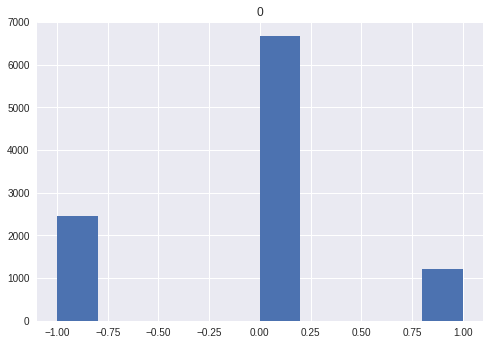

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_20_model_imb = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_20_model_imb.classes_)
print(intrinsic_20_model_imb.score(X_train_mixed, y_train_mixed))

[0 1]
0.6857198030317659
CPU times: user 519 ms, sys: 2.68 ms, total: 522 ms
Wall time: 523 ms


In [ ]:
y_pred = intrinsic_20_model_imb.predict(X_test)
print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.8884946781550938
0.6014492753623188


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
fpr_int_20_imb, tpr_int_20_imb, thresholds_int_20_imb = roc_curve(y_test, y_pred)
auc_int_20_imb = auc(fpr_int_20_imb, tpr_int_20_imb)

### Intrinsic - LabelSpreading - Balanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.20, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

under_sampler = RandomUnderSampler(random_state=12, sampling_strategy = 0.4)
X_train_undersampled, y_train_undersampled = under_sampler.fit_resample(X_train,y_train)

over_sampler = SMOTE(sampling_strategy=1.0)
X_train_sampled, y_train_sampled = over_sampler.fit_resample(X_train_undersampled, y_train_undersampled)

# create the training dataset input
X_train_mixed = np.concatenate((X_train_sampled, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train_sampled, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train_sampled.shape, y_train_sampled.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (6104, 7) (6104,)
Unlabeled Train Set: (2466, 7) (2466,)
Test Set: (1973, 7) (1973,)
CPU times: user 35.9 ms, sys: 0 ns, total: 35.9 ms
Wall time: 35.9 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feff7870c10>]],
      dtype=object)

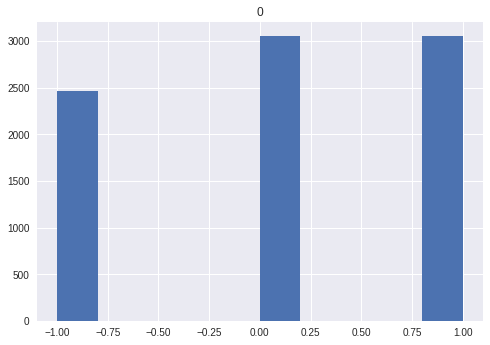

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_20_model_bal = LabelSpreading(alpha=0.1, max_iter=100, tol=0.01).fit(X_train_mixed, y_train_mixed)
print(intrinsic_20_model_bal.classes_)
print(intrinsic_20_model_bal.score(X_train_mixed, y_train_mixed))

[0 1]
0.5646441073512252
CPU times: user 6.51 s, sys: 321 ms, total: 6.83 s
Wall time: 5.53 s


In [ ]:
y_pred = intrinsic_20_model_bal.predict(X_test)

print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8712620375063356
0.6018808777429467


In [ ]:
fpr_int_20_bal, tpr_int_20_bal, thresholds_int_20_bal = roc_curve(y_test, y_pred)
auc_int_20_bal = auc(fpr_int_20_bal, tpr_int_20_bal)

# 4. 50% unlabelled, 50% labelled data 

### Self Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.5, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
st_acc_50_imb, st_f1_50_imb, st_50_imb_roc = selfTraining(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score)

Iteration 0
Test Accuracy: 0.8978102189781022
Train f1: 0.7865853658536586
Test f1: 0.5827814569536425
Now predicting labels for unlabeled data...
2833 high-probability predictions added to training data.
3332 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8978102189781022
Train f1: 0.7887537993920973
Test f1: 0.5855263157894738
Now predicting labels for unlabeled data...
459 high-probability predictions added to training data.
2873 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9018653690186537
Train f1: 0.7942942942942943
Test f1: 0.6158730158730159
Now predicting labels for unlabeled data...
322 high-probability predictions added to training data.
2551 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.9002433090024331
Train f1: 0.7987851176917236
Test f1: 0.5858585858585859
Now predicting labels for unlabeled data...
100 high-probability predictions added to training data.
2451 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.901054

### Self Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.5, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
st_acc_50_bal, st_f1_50_bal, st_50_bal_roc = selfTraining(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score, auto_balancing=True)

Iteration 0
Test Accuracy: 0.8986212489862125
Train f1: 0.785986290936786
Test f1: 0.5874587458745875
Now predicting labels for unlabeled data...
2830 high-probability predictions added to training data.
3335 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8718572587185726
Train f1: 0.9475306479859894
Test f1: 0.6708333333333333
Now predicting labels for unlabeled data...
79 high-probability predictions added to training data.
3256 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8710462287104623
Train f1: 0.9476180511962057
Test f1: 0.6694386694386695
Now predicting labels for unlabeled data...
38 high-probability predictions added to training data.
3218 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8726682887266829
Train f1: 0.9481060080477314
Test f1: 0.6735966735966736
Now predicting labels for unlabeled data...
29 high-probability predictions added to training data.
3189 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8694241686

### Co-Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.5, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)

view1 = selected_features
view2 = selected_features

confidence_score = 0.95

ct_acc_50_imb, ct_f1_50_imb, ct_50_imb_roc = coTraining(clf1, clf2, view1, view2, X_train,
                                                       y_train, X_unlabelled, X_test, y_test, confidence_score)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8799675587996756
Clf: 0: Train f1: 0.4278892072588348
Clf: 0: Test f1: 0.421875
Now predicting labels for unlabeled data...
528 high-probability predictions added to training data.
5637 unlabeled instances remaining.

Iteration 1, Classifier: 1
Clf: 1: Test Accuracy: 0.9051094890510949
Clf: 1: Train f1: 0.813159528243327
Clf: 1: Test f1: 0.6309148264984227
Now predicting labels for unlabeled data...
2242 high-probability predictions added to training data.
3395 unlabeled instances remaining.

Iteration 2, Classifier: 0
Clf: 0: Test Accuracy: 0.8799675587996756
Clf: 0: Train f1: 0.5506376594148537
Clf: 0: Test f1: 0.421875
Now predicting labels for unlabeled data...
20 high-probability predictions added to training data.
3375 unlabeled instances remaining.

Iteration 3, Classifier: 1
Clf: 1: Test Accuracy: 0.9034874290348743
Clf: 1: Train f1: 0.8185705558949297
Clf: 1: Test f1: 0.6123778501628665
Now predicting labels for unlabeled dat

### Co-Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.5, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)

view1 = selected_features
view2 = selected_features

confidence_score = 0.95

ct_acc_50_bal, ct_f1_50_bal, ct_50_bal_roc = coTraining(clf1, clf2, view1, view2, X_train, y_train, 
                                                       X_unlabelled, X_test, y_test, confidence_score,
                                                       auto_balancing=True)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8799675587996756
Clf: 0: Train f1: 0.4278892072588348
Clf: 0: Test f1: 0.421875
Now predicting labels for unlabeled data...
528 high-probability predictions added to training data.
5637 unlabeled instances remaining.

Iteration 1, Classifier: 1
Clf: 1: Test Accuracy: 0.8759124087591241
Clf: 1: Train f1: 0.9265209940017138
Clf: 1: Test f1: 0.6737739872068229
Now predicting labels for unlabeled data...
1293 high-probability predictions added to training data.
4344 unlabeled instances remaining.

Iteration 2, Classifier: 0
Clf: 0: Test Accuracy: 0.8523925385239254
Clf: 0: Train f1: 0.8114661654135338
Clf: 0: Test f1: 0.5687203791469194
Now predicting labels for unlabeled data...
335 high-probability predictions added to training data.
4009 unlabeled instances remaining.

Iteration 3, Classifier: 1
Clf: 1: Test Accuracy: 0.8734793187347932
Clf: 1: Train f1: 0.9422565837158734
Clf: 1: Test f1: 0.6694915254237288
Now predicting labels for u

### Semi-Supervised Ensemble - Imbalanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.5, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_50_imb, sse_f1_50_imb, sse_50_imb_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=False)


Iteration 0
Test Accuracy: 0.8953771289537713
Train f1: 0.71294287780188
Test f1: 0.6126126126126126
Now predicting labels for unlabeled data...
3436 high-probability predictions added to training data.
2729 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8994322789943228
Train f1: 0.7287784679089025
Test f1: 0.6374269005847953
Now predicting labels for unlabeled data...
366 high-probability predictions added to training data.
2363 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8961881589618816
Train f1: 0.7354925775978408
Test f1: 0.621301775147929
Now predicting labels for unlabeled data...
171 high-probability predictions added to training data.
2192 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8986212489862125
Train f1: 0.7389292795769994
Test f1: 0.6246246246246246
Now predicting labels for unlabeled data...
83 high-probability predictions added to training data.
2109 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.9018653690

### Semi-Supervised Ensemble - Balanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.5, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_50_bal, sse_f1_50_bal, sse_50_bal_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=True)


Iteration 0
Test Accuracy: 0.8953771289537713
Train f1: 0.71294287780188
Test f1: 0.6126126126126126
Now predicting labels for unlabeled data...
3436 high-probability predictions added to training data.
2729 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8734793187347932
Train f1: 0.9425558393921529
Test f1: 0.6708860759493671
Now predicting labels for unlabeled data...
226 high-probability predictions added to training data.
2503 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8734793187347932
Train f1: 0.9419412402013894
Test f1: 0.6708860759493671
Now predicting labels for unlabeled data...
52 high-probability predictions added to training data.
2451 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8726682887266829
Train f1: 0.9420574982547439
Test f1: 0.6694736842105264
Now predicting labels for unlabeled data...
26 high-probability predictions added to training data.
2425 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8742903487

### Unsupervised labelling - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.5, holdout_test_size=0.2)


clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
usl_acc_50_imb, usl_f1_50_imb, usl_50_imb_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=False)

(6165, 20) (6165,)
Iteration 0
Test Accuracy: 0.8897893030794165
Train f1: 0.7829614604462475
Test f1: 0.5750000000000001
Now predicting labels for unlabeled data...
2912 high-probability predictions added to training data.
3253 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8849270664505673
Train f1: 0.7897227856659905
Test f1: 0.5359477124183006
Now predicting labels for unlabeled data...
490 high-probability predictions added to training data.
2763 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8833063209076175
Train f1: 0.7872195785180149
Test f1: 0.52
Now predicting labels for unlabeled data...
233 high-probability predictions added to training data.
2530 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8849270664505673
Train f1: 0.7913571910871033
Test f1: 0.5359477124183006
Now predicting labels for unlabeled data...
124 high-probability predictions added to training data.
2406 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8

### Unsupervised labelling - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.5, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
usl_acc_50_bal, usl_f1_50_bal, usl_50_bal_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=True)

(6165, 20) (6165,)
Iteration 0
Test Accuracy: 0.893030794165316
Train f1: 0.7788331071913162
Test f1: 0.5599999999999999
Now predicting labels for unlabeled data...
2807 high-probability predictions added to training data.
doing balancing
applying smote
3358 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.86709886547812
Train f1: 0.9428571428571428
Test f1: 0.6403508771929824
Now predicting labels for unlabeled data...
56 high-probability predictions added to training data.
doing balancing
applying smote
3302 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8703403565640194
Train f1: 0.9432508326258733
Test f1: 0.6491228070175439
Now predicting labels for unlabeled data...
50 high-probability predictions added to training data.
doing balancing
applying smote
3252 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8719611021069692
Train f1: 0.9435164120896976
Test f1: 0.6550218340611353
Now predicting labels for unlabeled data...
13 high-probability pr

### Intrinsic - LabelSpreading - Imbalanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.50, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

# create the training dataset input
X_train_mixed = np.concatenate((X_train, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train.shape, y_train.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (4932, 7) (4932,)
Unlabeled Train Set: (6165, 7) (6165,)
Test Set: (1233, 7) (1233,)
CPU times: user 23.6 ms, sys: 0 ns, total: 23.6 ms
Wall time: 22.7 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feff77c2050>]],
      dtype=object)

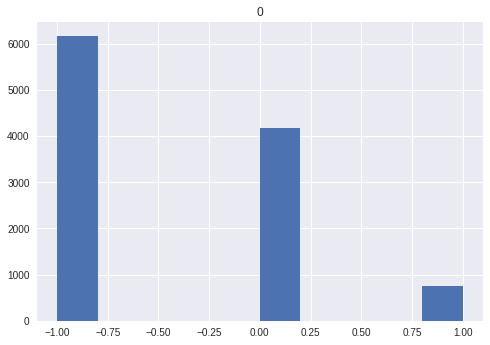

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_50_model_imb = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_50_model_imb.classes_)
print(intrinsic_50_model_imb.score(X_train_mixed, y_train_mixed))

[0 1]
0.3995674506623412
CPU times: user 575 ms, sys: 5.93 ms, total: 581 ms
Wall time: 580 ms


In [ ]:
y_pred = intrinsic_50_model_imb.predict(X_test)
print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.8848337388483374
0.5590062111801243


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
fpr_int_50_imb, tpr_int_50_imb, thresholds_int_50_imb = roc_curve(y_test, y_pred)
auc_int_50_imb = auc(fpr_int_50_imb, tpr_int_50_imb)

### Intrinsic - LabelSpreading - Balanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.50, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

under_sampler = RandomUnderSampler(random_state=12, sampling_strategy = 0.4)
X_train_undersampled, y_train_undersampled = under_sampler.fit_resample(X_train,y_train)

over_sampler = SMOTE(sampling_strategy=1.0)
X_train_sampled, y_train_sampled = over_sampler.fit_resample(X_train_undersampled, y_train_undersampled)

# create the training dataset input
X_train_mixed = np.concatenate((X_train_sampled, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train_sampled, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train_sampled.shape, y_train_sampled.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (3814, 7) (3814,)
Unlabeled Train Set: (6165, 7) (6165,)
Test Set: (1233, 7) (1233,)
CPU times: user 31.5 ms, sys: 1.83 ms, total: 33.3 ms
Wall time: 37.8 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feff7764f90>]],
      dtype=object)

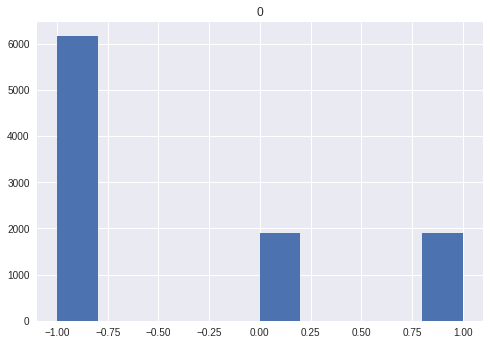

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_50_model_bal = LabelSpreading(alpha=0.1, max_iter=100, tol=0.01).fit(X_train_mixed, y_train_mixed)
print(intrinsic_50_model_bal.classes_)
print(intrinsic_50_model_bal.score(X_train_mixed, y_train_mixed))

[0 1]
0.29762501252630524
CPU times: user 8.89 s, sys: 417 ms, total: 9.31 s
Wall time: 7.62 s


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [ ]:
y_pred = intrinsic_50_model_bal.predict(X_test)

print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8759124087591241
0.5898123324396783


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [ ]:
fpr_int_50_bal, tpr_int_50_bal, thresholds_int_50_bal = roc_curve(y_test, y_pred)
auc_int_50_bal = auc(fpr_int_50_bal, tpr_int_50_bal)

# 5. 90% unlabelled, 10% labelled data 

### Self Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.9, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
st_acc_90_imb, st_f1_90_imb, st_90_imb_roc = selfTraining(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score)

Iteration 0
Test Accuracy: 0.8906882591093117
Train f1: 0.8840579710144928
Test f1: 0.5846153846153846
Now predicting labels for unlabeled data...
4566 high-probability predictions added to training data.
6531 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8825910931174089
Train f1: 0.862453531598513
Test f1: 0.5396825396825397
Now predicting labels for unlabeled data...
1966 high-probability predictions added to training data.
4565 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8825910931174089
Train f1: 0.870848708487085
Test f1: 0.5245901639344263
Now predicting labels for unlabeled data...
839 high-probability predictions added to training data.
3726 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8866396761133604
Train f1: 0.870848708487085
Test f1: 0.5483870967741936
Now predicting labels for unlabeled data...
367 high-probability predictions added to training data.
3359 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.89068825

### Self Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.9, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
st_acc_90_bal, st_f1_90_bal, st_90_bal_roc = selfTraining(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score, auto_balancing=True)

Iteration 0
Test Accuracy: 0.8987854251012146
Train f1: 0.8727272727272727
Test f1: 0.6031746031746031
Now predicting labels for unlabeled data...
4520 high-probability predictions added to training data.
6577 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8380566801619433
Train f1: 0.9888517279821627
Test f1: 0.5833333333333334
Now predicting labels for unlabeled data...
953 high-probability predictions added to training data.
5624 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8421052631578947
Train f1: 0.9902928731436157
Test f1: 0.5894736842105264
Now predicting labels for unlabeled data...
401 high-probability predictions added to training data.
5223 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8421052631578947
Train f1: 0.9912014077747561
Test f1: 0.5894736842105264
Now predicting labels for unlabeled data...
243 high-probability predictions added to training data.
4980 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.842105

### Co-Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.9, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)

view1 = selected_features
view2 = selected_features

confidence_score = 0.95

ct_acc_90_imb, ct_f1_90_imb, ct_90_imb_roc = coTraining(clf1, clf2, view1, view2, X_train,
                                                       y_train, X_unlabelled, X_test, y_test, confidence_score)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8825910931174089
Clf: 0: Train f1: 0.35789473684210527
Clf: 0: Test f1: 0.4081632653061224
Now predicting labels for unlabeled data...
681 high-probability predictions added to training data.
10416 unlabeled instances remaining.

Iteration 1, Classifier: 1
Clf: 1: Test Accuracy: 0.8906882591093117
Clf: 1: Train f1: 0.9658536585365853
Clf: 1: Test f1: 0.6086956521739131
Now predicting labels for unlabeled data...
3224 high-probability predictions added to training data.
7192 unlabeled instances remaining.

Iteration 2, Classifier: 0
Clf: 0: Test Accuracy: 0.8866396761133604
Clf: 0: Train f1: 0.8984509466437177
Clf: 0: Test f1: 0.4814814814814815
Now predicting labels for unlabeled data...
6132 high-probability predictions added to training data.
1060 unlabeled instances remaining.

Iteration 3, Classifier: 1
Clf: 1: Test Accuracy: 0.902834008097166
Clf: 1: Train f1: 0.9318936877076412
Clf: 1: Test f1: 0.6129032258064516
Now predicting 

### Co-Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.9, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)

view1 = selected_features
view2 = selected_features

confidence_score = 0.95

ct_acc_90_bal, ct_f1_90_bal, ct_90_bal_roc = coTraining(clf1, clf2, view1, view2, X_train, y_train, 
                                                       X_unlabelled, X_test, y_test, confidence_score,
                                                       auto_balancing=True)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8825910931174089
Clf: 0: Train f1: 0.35789473684210527
Clf: 0: Test f1: 0.4081632653061224
Now predicting labels for unlabeled data...
701 high-probability predictions added to training data.
10396 unlabeled instances remaining.

Iteration 1, Classifier: 1
Clf: 1: Test Accuracy: 0.8582995951417004
Clf: 1: Train f1: 0.9708920187793427
Clf: 1: Test f1: 0.5569620253164557
Now predicting labels for unlabeled data...
3116 high-probability predictions added to training data.
7280 unlabeled instances remaining.

Iteration 2, Classifier: 0
Clf: 0: Test Accuracy: 0.8866396761133604
Clf: 0: Train f1: 0.9399399399399401
Clf: 0: Test f1: 0.6111111111111113
Now predicting labels for unlabeled data...
614 high-probability predictions added to training data.
6666 unlabeled instances remaining.

Iteration 3, Classifier: 1
Clf: 1: Test Accuracy: 0.8461538461538461
Clf: 1: Train f1: 0.9869531849577898
Clf: 1: Test f1: 0.5957446808510638
Now predicting 

### Semi-Supervised Ensemble - Imbalanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.9, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_90_imb, sse_f1_90_imb, sse_90_imb_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=False)


Iteration 0
Test Accuracy: 0.8866396761133604
Train f1: 0.8960573476702509
Test f1: 0.6
Now predicting labels for unlabeled data...
7051 high-probability predictions added to training data.
4046 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8987854251012146
Train f1: 0.9508982035928143
Test f1: 0.6268656716417911
Now predicting labels for unlabeled data...
1609 high-probability predictions added to training data.
2437 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8987854251012146
Train f1: 0.9633173843700158
Test f1: 0.6153846153846153
Now predicting labels for unlabeled data...
531 high-probability predictions added to training data.
1906 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8947368421052632
Train f1: 0.964260686755431
Test f1: 0.6060606060606061
Now predicting labels for unlabeled data...
189 high-probability predictions added to training data.
1717 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8947368421052632
Trai

### Semi-Supervised Ensemble - Balanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.9, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_90_bal, sse_f1_90_bal, sse_90_bal_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=True)


Iteration 0
Test Accuracy: 0.8866396761133604
Train f1: 0.8960573476702509
Test f1: 0.6
Now predicting labels for unlabeled data...
7051 high-probability predictions added to training data.
4046 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8502024291497976
Train f1: 0.9917973620316293
Test f1: 0.5934065934065935
Now predicting labels for unlabeled data...
1275 high-probability predictions added to training data.
2771 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8461538461538461
Train f1: 0.9922703577206543
Test f1: 0.5869565217391304
Now predicting labels for unlabeled data...
492 high-probability predictions added to training data.
2279 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8461538461538461
Train f1: 0.9921713101542712
Test f1: 0.5869565217391304
Now predicting labels for unlabeled data...
330 high-probability predictions added to training data.
1949 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8461538461538461
Tra

### Unsupervised labelling - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.9, holdout_test_size=0.2)


clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
usl_acc_90_imb, usl_f1_90_imb, usl_90_imb_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=False)

(1233, 20) (1233,)
Iteration 0
Test Accuracy: 0.8870967741935484
Train f1: 0.8552631578947368
Test f1: 0.5
Now predicting labels for unlabeled data...
4181 high-probability predictions added to training data.
6916 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9032258064516129
Train f1: 0.8389261744966442
Test f1: 0.6
Now predicting labels for unlabeled data...
1869 high-probability predictions added to training data.
5047 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8870967741935484
Train f1: 0.8259385665529011
Test f1: 0.5
Now predicting labels for unlabeled data...
781 high-probability predictions added to training data.
4266 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8951612903225806
Train f1: 0.8082191780821918
Test f1: 0.5517241379310345
Now predicting labels for unlabeled data...
601 high-probability predictions added to training data.
3665 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8870967741935484
Train f1: 0.83

### Unsupervised labelling - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.9, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
usl_acc_90_bal, usl_f1_90_bal, usl_90_bal_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=True)

(1233, 20) (1233,)
Iteration 0
Test Accuracy: 0.8548387096774194
Train f1: 0.8673139158576053
Test f1: 0.47058823529411764
Now predicting labels for unlabeled data...
4453 high-probability predictions added to training data.
doing balancing
applying smote
6644 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8306451612903226
Train f1: 0.986147026228297
Test f1: 0.5882352941176471
Now predicting labels for unlabeled data...
614 high-probability predictions added to training data.
doing balancing
applying smote
6030 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8306451612903226
Train f1: 0.987164934951541
Test f1: 0.5882352941176471
Now predicting labels for unlabeled data...
493 high-probability predictions added to training data.
doing balancing
applying smote
5537 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8306451612903226
Train f1: 0.9876440140257138
Test f1: 0.5882352941176471
Now predicting labels for unlabeled data...
252 high-probabili

### Intrinsic - LabelSpreading - Imbalanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.90, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

# create the training dataset input
X_train_mixed = np.concatenate((X_train, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train.shape, y_train.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (986, 7) (986,)
Unlabeled Train Set: (11097, 7) (11097,)
Test Set: (247, 7) (247,)
CPU times: user 14.8 ms, sys: 967 µs, total: 15.7 ms
Wall time: 15.8 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feff7680f90>]],
      dtype=object)

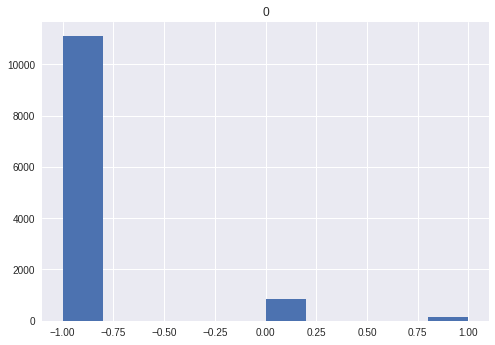

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_90_model_imb = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_90_model_imb.classes_)
print(intrinsic_90_model_imb.score(X_train_mixed, y_train_mixed))

[0 1]
0.07804353223537201
CPU times: user 615 ms, sys: 8.23 ms, total: 624 ms
Wall time: 625 ms


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [ ]:
y_pred = intrinsic_90_model_imb.predict(X_test)
print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.8623481781376519
0.48484848484848486


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [ ]:
fpr_int_90_imb, tpr_int_90_imb, thresholds_int_90_imb = roc_curve(y_test, y_pred)
auc_int_90_imb = auc(fpr_int_90_imb, tpr_int_90_imb)

### Intrinsic - LabelSpreading - Balanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.90, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

under_sampler = RandomUnderSampler(random_state=12, sampling_strategy = 0.4)
X_train_undersampled, y_train_undersampled = under_sampler.fit_resample(X_train,y_train)

over_sampler = SMOTE(sampling_strategy=1.0)
X_train_sampled, y_train_sampled = over_sampler.fit_resample(X_train_undersampled, y_train_undersampled)

# create the training dataset input
X_train_mixed = np.concatenate((X_train_sampled, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train_sampled, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train_sampled.shape, y_train_sampled.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (764, 7) (764,)
Unlabeled Train Set: (11097, 7) (11097,)
Test Set: (247, 7) (247,)
CPU times: user 24.8 ms, sys: 0 ns, total: 24.8 ms
Wall time: 24.9 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feff7602e10>]],
      dtype=object)

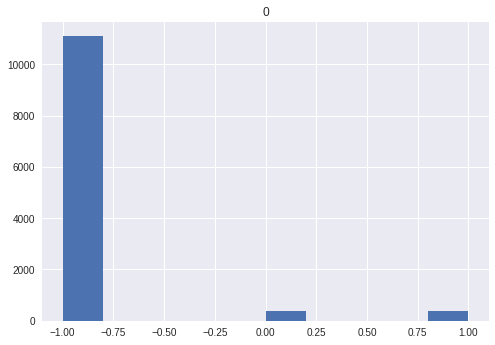

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_90_model_bal = LabelSpreading(alpha=0.1, max_iter=100, tol=0.01).fit(X_train_mixed, y_train_mixed)
print(intrinsic_90_model_bal.classes_)
print(intrinsic_90_model_bal.score(X_train_mixed, y_train_mixed))

[0 1]
0.049068375347778435
CPU times: user 12.3 s, sys: 677 ms, total: 13 s
Wall time: 11 s


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [ ]:
y_pred = intrinsic_90_model_bal.predict(X_test)

print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


0.8866396761133604
0.6111111111111113


In [ ]:
fpr_int_90_bal, tpr_int_90_bal, thresholds_int_90_bal = roc_curve(y_test, y_pred)
auc_int_90_bal = auc(fpr_int_90_bal, tpr_int_90_bal)

# 6. 95% unlabelled, 5% labelled data 

### Self Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.95, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
st_acc_95_imb, st_f1_95_imb, st_95_imb_roc = selfTraining(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score)

Iteration 0
Test Accuracy: 0.9032258064516129
Train f1: 0.8125000000000001
Test f1: 0.5714285714285714
Now predicting labels for unlabeled data...
3331 high-probability predictions added to training data.
8383 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8870967741935484
Train f1: 0.7936507936507937
Test f1: 0.46153846153846156
Now predicting labels for unlabeled data...
2464 high-probability predictions added to training data.
5919 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9032258064516129
Train f1: 0.7936507936507937
Test f1: 0.625
Now predicting labels for unlabeled data...
1047 high-probability predictions added to training data.
4872 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8951612903225806
Train f1: 0.7839999999999999
Test f1: 0.5517241379310345
Now predicting labels for unlabeled data...
491 high-probability predictions added to training data.
4381 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8951612903225806

### Self Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.95, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
st_acc_95_bal, st_f1_95_bal, st_95_bal_roc = selfTraining(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score, auto_balancing=True)

Iteration 0
Test Accuracy: 0.9032258064516129
Train f1: 0.8031496062992126
Test f1: 0.5714285714285714
Now predicting labels for unlabeled data...
3486 high-probability predictions added to training data.
8228 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8790322580645161
Train f1: 0.9928461931527849
Test f1: 0.6938775510204083
Now predicting labels for unlabeled data...
1171 high-probability predictions added to training data.
7057 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8790322580645161
Train f1: 0.9939555373424854
Test f1: 0.6938775510204083
Now predicting labels for unlabeled data...
596 high-probability predictions added to training data.
6461 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8709677419354839
Train f1: 0.9941904047976011
Test f1: 0.6799999999999999
Now predicting labels for unlabeled data...
293 high-probability predictions added to training data.
6168 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.87903

### Co-Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.95, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)

view1 = selected_features
view2 = selected_features

confidence_score = 0.95

ct_acc_95_imb, ct_f1_95_imb, ct_95_imb_roc = coTraining(clf1, clf2, view1, view2, X_train,
                                                       y_train, X_unlabelled, X_test, y_test, confidence_score)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8629032258064516
Clf: 0: Train f1: 0.29213483146067415
Clf: 0: Test f1: 0.1904761904761905
Now predicting labels for unlabeled data...
649 high-probability predictions added to training data.
11065 unlabeled instances remaining.

Iteration 1, Classifier: 1
Clf: 1: Test Accuracy: 0.8548387096774194
Clf: 1: Train f1: 0.9552572706935123
Clf: 1: Test f1: 0.25
Now predicting labels for unlabeled data...
2346 high-probability predictions added to training data.
8719 unlabeled instances remaining.

Iteration 2, Classifier: 0
Clf: 0: Test Accuracy: 0.8548387096774194
Clf: 0: Train f1: 0.8836206896551725
Clf: 0: Test f1: 0.3076923076923077
Now predicting labels for unlabeled data...
7829 high-probability predictions added to training data.
890 unlabeled instances remaining.

Iteration 3, Classifier: 1
Clf: 1: Test Accuracy: 0.8629032258064516
Clf: 1: Train f1: 0.9239631336405529
Clf: 1: Test f1: 0.1904761904761905
Now predicting labels for unl

### Co-Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.95, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)

view1 = selected_features
view2 = selected_features

confidence_score = 0.95

ct_acc_95_bal, ct_f1_95_bal, ct_95_bal_roc = coTraining(clf1, clf2, view1, view2, X_train, y_train, 
                                                       X_unlabelled, X_test, y_test, confidence_score,
                                                       auto_balancing=True)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8629032258064516
Clf: 0: Train f1: 0.29213483146067415
Clf: 0: Test f1: 0.1904761904761905
Now predicting labels for unlabeled data...
262 high-probability predictions added to training data.
11452 unlabeled instances remaining.

Iteration 1, Classifier: 1
Clf: 1: Test Accuracy: 0.8951612903225806
Clf: 1: Train f1: 0.9690476190476189
Clf: 1: Test f1: 0.6060606060606061
Now predicting labels for unlabeled data...
2885 high-probability predictions added to training data.
8567 unlabeled instances remaining.

Iteration 2, Classifier: 0
Clf: 0: Test Accuracy: 0.8387096774193549
Clf: 0: Train f1: 0.9556852231509227
Clf: 0: Test f1: 0.5454545454545454
Now predicting labels for unlabeled data...
1065 high-probability predictions added to training data.
7502 unlabeled instances remaining.

Iteration 3, Classifier: 1
Clf: 1: Test Accuracy: 0.8064516129032258
Clf: 1: Train f1: 0.9916745956232159
Clf: 1: Test f1: 0.6
Now predicting labels for unl

### Semi-Supervised Ensemble - Imbalanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.95, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_95_imb, sse_f1_95_imb, sse_95_imb_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=False)


Iteration 0
Test Accuracy: 0.9193548387096774
Train f1: 0.9517241379310345
Test f1: 0.7368421052631579
Now predicting labels for unlabeled data...
7585 high-probability predictions added to training data.
4129 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9193548387096774
Train f1: 0.9864077669902913
Test f1: 0.7500000000000001
Now predicting labels for unlabeled data...
2223 high-probability predictions added to training data.
1906 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9193548387096774
Train f1: 0.9899497487437187
Test f1: 0.7500000000000001
Now predicting labels for unlabeled data...
675 high-probability predictions added to training data.
1231 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.9274193548387096
Train f1: 0.9888042991491266
Test f1: 0.7804878048780488
Now predicting labels for unlabeled data...
172 high-probability predictions added to training data.
1059 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.93548

### Semi-Supervised Ensemble - Balanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.95, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_95_bal, sse_f1_95_bal, sse_95_bal_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=True)


Iteration 0
Test Accuracy: 0.9193548387096774
Train f1: 0.9517241379310345
Test f1: 0.7368421052631579
Now predicting labels for unlabeled data...
7585 high-probability predictions added to training data.
4129 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8951612903225806
Train f1: 0.9977492387130942
Test f1: 0.7111111111111111
Now predicting labels for unlabeled data...
2075 high-probability predictions added to training data.
2054 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8870967741935484
Train f1: 0.9974903034451289
Test f1: 0.6956521739130435
Now predicting labels for unlabeled data...
618 high-probability predictions added to training data.
1436 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8951612903225806
Train f1: 0.9973434535104363
Test f1: 0.7234042553191489
Now predicting labels for unlabeled data...
245 high-probability predictions added to training data.
1191 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.88709

### Unsupervised labelling - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X, y,
                                                                      unlabelled_size=0.95, holdout_test_size=0.2)


clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
usl_acc_95_imb, usl_f1_95_imb, usl_95_imb_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=False)

(616, 20) (616,)
Iteration 0
Test Accuracy: 0.8548387096774194
Train f1: 0.7943262411347518
Test f1: 0.47058823529411764
Now predicting labels for unlabeled data...
3605 high-probability predictions added to training data.
8109 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8870967741935484
Train f1: 0.7857142857142858
Test f1: 0.631578947368421
Now predicting labels for unlabeled data...
2618 high-probability predictions added to training data.
5491 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9032258064516129
Train f1: 0.7943262411347518
Test f1: 0.7
Now predicting labels for unlabeled data...
1368 high-probability predictions added to training data.
4123 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.9193548387096774
Train f1: 0.8028169014084507
Test f1: 0.7368421052631577
Now predicting labels for unlabeled data...
472 high-probability predictions added to training data.
3651 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.88

### Unsupervised labelling - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.95, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_jobs=-1)
confidence_score = 0.95
usl_acc_95_bal, usl_f1_95_bal, usl_95_bal_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=True)

(616, 20) (616,)
Iteration 0
Test Accuracy: 0.8870967741935484
Train f1: 0.8194444444444444
Test f1: 0.5333333333333333
Now predicting labels for unlabeled data...
3751 high-probability predictions added to training data.
doing balancing
applying smote
7963 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8709677419354839
Train f1: 0.9920887944267328
Test f1: 0.6923076923076923
Now predicting labels for unlabeled data...
1136 high-probability predictions added to training data.
doing balancing
applying smote
6827 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8709677419354839
Train f1: 0.9933877868533644
Test f1: 0.6923076923076923
Now predicting labels for unlabeled data...
573 high-probability predictions added to training data.
doing balancing
applying smote
6254 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8709677419354839
Train f1: 0.9937432963889882
Test f1: 0.6923076923076923
Now predicting labels for unlabeled data...
416 high-probabili

### Intrinsic - LabelSpreading - Imbalanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.95, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

# create the training dataset input
X_train_mixed = np.concatenate((X_train, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train.shape, y_train.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (492, 7) (492,)
Unlabeled Train Set: (11714, 7) (11714,)
Test Set: (124, 7) (124,)
CPU times: user 18.4 ms, sys: 2.98 ms, total: 21.4 ms
Wall time: 22.5 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feff7587bd0>]],
      dtype=object)

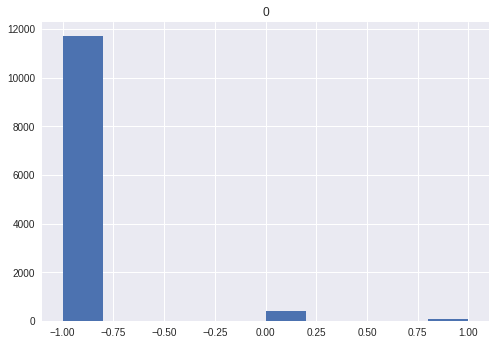

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_95_model_imb = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_95_model_imb.classes_)
print(intrinsic_95_model_imb.score(X_train_mixed, y_train_mixed))

[0 1]
0.03940684909061117
CPU times: user 643 ms, sys: 13.9 ms, total: 657 ms
Wall time: 655 ms


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [ ]:
y_pred = intrinsic_95_model_imb.predict(X_test)
print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.8387096774193549
0.5


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [ ]:
fpr_int_95_imb, tpr_int_95_imb, thresholds_int_95_imb = roc_curve(y_test, y_pred)
auc_int_95_imb = auc(fpr_int_95_imb, tpr_int_95_imb)

### Intrinsic - LabelSpreading - Balanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.95, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

under_sampler = RandomUnderSampler(random_state=12, sampling_strategy = 0.4)
X_train_undersampled, y_train_undersampled = under_sampler.fit_resample(X_train,y_train)

over_sampler = SMOTE(sampling_strategy=1.0)
X_train_sampled, y_train_sampled = over_sampler.fit_resample(X_train_undersampled, y_train_undersampled)

# create the training dataset input
X_train_mixed = np.concatenate((X_train_sampled, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train_sampled, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train_sampled.shape, y_train_sampled.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (380, 7) (380,)
Unlabeled Train Set: (11714, 7) (11714,)
Test Set: (124, 7) (124,)
CPU times: user 34 ms, sys: 2.13 ms, total: 36.1 ms
Wall time: 37.3 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feff7587c90>]],
      dtype=object)

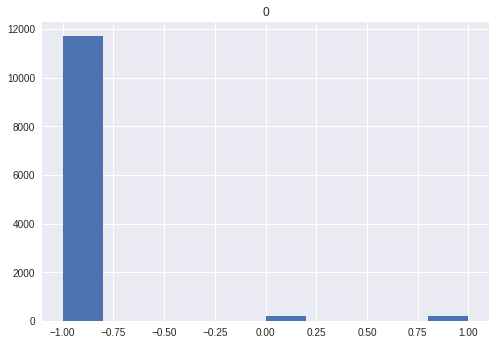

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_95_model_bal = LabelSpreading(alpha=0.1, max_iter=100, tol=0.01).fit(X_train_mixed, y_train_mixed)
print(intrinsic_95_model_bal.classes_)
print(intrinsic_95_model_bal.score(X_train_mixed, y_train_mixed))

[0 1]
0.02472300314205391
CPU times: user 14 s, sys: 1.65 s, total: 15.6 s
Wall time: 13.1 s


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [ ]:
y_pred = intrinsic_95_model_bal.predict(X_test)

print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.8709677419354839
0.5555555555555555


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
fpr_int_95_bal, tpr_int_95_bal, thresholds_int_95_bal = roc_curve(y_test, y_pred)
auc_int_95_bal = auc(fpr_int_95_bal, tpr_int_95_bal)

# ROC Curves

### 1. Fully Supervised

<Figure size 576x396 with 0 Axes>

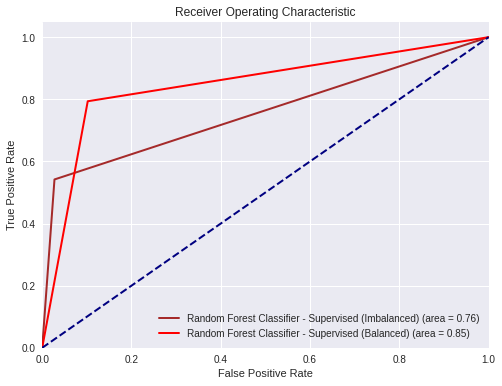

In [ ]:
plt.figure()
lw = 2
plt.figure(figsize=(8,6))

plt.plot(fpr_imb, tpr_imb, color='brown',
         lw=lw, label='Random Forest Classifier - Supervised (Imbalanced) (area = %0.2f)' % roc_auc_imb)
plt.plot(fpr_bal, tpr_bal, color='red',
         lw=lw, label='Random Forest Classifier - Supervised (Balanced) (area = %0.2f)' % roc_auc_bal)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 2. 10% Unlabeled Data

<Figure size 432x288 with 0 Axes>

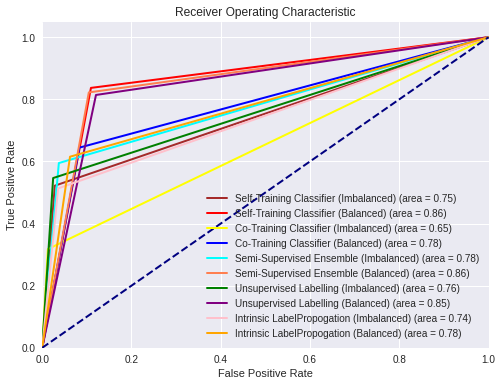

In [ ]:
fpr_st_10_imb, tpr_st_10_imb, auc_st_10_imb = st_10_imb_roc
fpr_st_10_bal, tpr_st_10_bal, auc_st_10_bal = st_10_bal_roc
fpr_ct_10_imb, tpr_ct_10_imb, auc_ct_10_imb = ct_10_imb_roc
fpr_ct_10_bal, tpr_ct_10_bal, auc_ct_10_bal = ct_10_bal_roc
fpr_sse_10_imb, tpr_sse_10_imb, auc_sse_10_imb = sse_10_imb_roc
fpr_sse_10_bal, tpr_sse_10_bal, auc_sse_10_bal = sse_10_bal_roc
fpr_usl_10_imb, tpr_usl_10_imb, auc_usl_10_imb = usl_10_imb_roc
fpr_usl_10_bal, tpr_usl_10_bal, auc_usl_10_bal = usl_10_bal_roc


plt.figure()
lw = 2
plt.figure(figsize=(8,6))

plt.plot(fpr_st_10_imb, tpr_st_10_imb, color='brown',
         lw=lw, label='Self-Training Classifier (Imbalanced) (area = %0.2f)' % auc_st_10_imb)
plt.plot(fpr_st_10_bal, tpr_st_10_bal, color='red',
         lw=lw, label='Self-Training Classifier (Balanced) (area = %0.2f)' % auc_st_10_bal)
plt.plot(fpr_ct_10_imb, tpr_ct_10_imb, color='yellow',
         lw=lw, label='Co-Training Classifier (Imbalanced) (area = %0.2f)' % auc_ct_10_imb)
plt.plot(fpr_ct_10_bal, tpr_ct_10_bal, color='blue',
         lw=lw, label='Co-Training Classifier (Balanced) (area = %0.2f)' % auc_ct_10_bal)
plt.plot(fpr_sse_10_imb, tpr_sse_10_imb, color='aqua',
         lw=lw, label='Semi-Supervised Ensemble (Imbalanced) (area = %0.2f)' % auc_sse_10_imb)
plt.plot(fpr_sse_10_bal, tpr_sse_10_bal, color='coral',
         lw=lw, label='Semi-Supervised Ensemble (Balanced) (area = %0.2f)' % auc_sse_10_bal)
plt.plot(fpr_usl_10_imb, tpr_usl_10_imb, color='green',
         lw=lw, label='Unsupervised Labelling (Imbalanced) (area = %0.2f)' % auc_usl_10_imb)
plt.plot(fpr_usl_10_bal, tpr_usl_10_bal, color='purple',
         lw=lw, label='Unsupervised Labelling (Balanced) (area = %0.2f)' % auc_usl_10_bal)
plt.plot(fpr_int_10_imb, tpr_int_10_imb, color='pink',
         lw=lw, label='Intrinsic LabelSpreading (Imbalanced) (area = %0.2f)' % auc_int_10_imb)
plt.plot(fpr_int_10_bal, tpr_int_10_bal, color='orange',
         lw=lw, label='Intrinsic LabelSpreading (Balanced) (area = %0.2f)' % auc_int_10_bal)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 3. 20% Unlabeled Data

<Figure size 432x288 with 0 Axes>

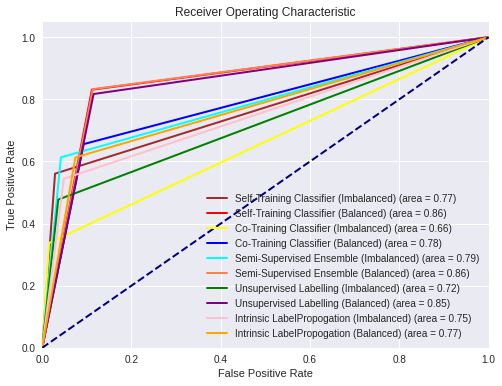

In [ ]:
fpr_st_20_imb, tpr_st_20_imb, auc_st_20_imb = st_20_imb_roc
fpr_st_20_bal, tpr_st_20_bal, auc_st_20_bal = st_20_bal_roc
fpr_ct_20_imb, tpr_ct_20_imb, auc_ct_20_imb = ct_20_imb_roc
fpr_ct_20_bal, tpr_ct_20_bal, auc_ct_20_bal = ct_20_bal_roc
fpr_sse_20_imb, tpr_sse_20_imb, auc_sse_20_imb = sse_20_imb_roc
fpr_sse_20_bal, tpr_sse_20_bal, auc_sse_20_bal = sse_20_bal_roc
fpr_usl_20_imb, tpr_usl_20_imb, auc_usl_20_imb = usl_20_imb_roc
fpr_usl_20_bal, tpr_usl_20_bal, auc_usl_20_bal = usl_20_bal_roc


plt.figure()
lw = 2
plt.figure(figsize=(8,6))

plt.plot(fpr_st_20_imb, tpr_st_20_imb, color='brown',
         lw=lw, label='Self-Training Classifier (Imbalanced) (area = %0.2f)' % auc_st_20_imb)
plt.plot(fpr_st_20_bal, tpr_st_20_bal, color='red',
         lw=lw, label='Self-Training Classifier (Balanced) (area = %0.2f)' % auc_st_20_bal)
plt.plot(fpr_ct_20_imb, tpr_ct_20_imb, color='yellow',
         lw=lw, label='Co-Training Classifier (Imbalanced) (area = %0.2f)' % auc_ct_20_imb)
plt.plot(fpr_ct_20_bal, tpr_ct_20_bal, color='blue',
         lw=lw, label='Co-Training Classifier (Balanced) (area = %0.2f)' % auc_ct_20_bal)
plt.plot(fpr_sse_20_imb, tpr_sse_20_imb, color='aqua',
         lw=lw, label='Semi-Supervised Ensemble (Imbalanced) (area = %0.2f)' % auc_sse_20_imb)
plt.plot(fpr_sse_20_bal, tpr_sse_20_bal, color='coral',
         lw=lw, label='Semi-Supervised Ensemble (Balanced) (area = %0.2f)' % auc_sse_20_bal)
plt.plot(fpr_usl_20_imb, tpr_usl_20_imb, color='green',
         lw=lw, label='Unsupervised Labelling (Imbalanced) (area = %0.2f)' % auc_usl_20_imb)
plt.plot(fpr_usl_20_bal, tpr_usl_20_bal, color='purple',
         lw=lw, label='Unsupervised Labelling (Balanced) (area = %0.2f)' % auc_usl_20_bal)
plt.plot(fpr_int_20_imb, tpr_int_20_imb, color='pink',
         lw=lw, label='Intrinsic LabelSpreading (Imbalanced) (area = %0.2f)' % auc_int_20_imb)
plt.plot(fpr_int_20_bal, tpr_int_20_bal, color='orange',
         lw=lw, label='Intrinsic LabelSpreading (Balanced) (area = %0.2f)' % auc_int_20_bal)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 4. 50% Unlabeled Data

<Figure size 432x288 with 0 Axes>

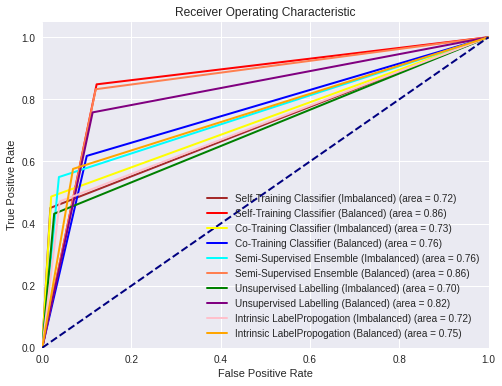

In [ ]:
fpr_st_50_imb, tpr_st_50_imb, auc_st_50_imb = st_50_imb_roc
fpr_st_50_bal, tpr_st_50_bal, auc_st_50_bal = st_50_bal_roc
fpr_ct_50_imb, tpr_ct_50_imb, auc_ct_50_imb = ct_50_imb_roc
fpr_ct_50_bal, tpr_ct_50_bal, auc_ct_50_bal = ct_50_bal_roc
fpr_sse_50_imb, tpr_sse_50_imb, auc_sse_50_imb = sse_50_imb_roc
fpr_sse_50_bal, tpr_sse_50_bal, auc_sse_50_bal = sse_50_bal_roc
fpr_usl_50_imb, tpr_usl_50_imb, auc_usl_50_imb = usl_50_imb_roc
fpr_usl_50_bal, tpr_usl_50_bal, auc_usl_50_bal = usl_50_bal_roc


plt.figure()
lw = 2
plt.figure(figsize=(8,6))

plt.plot(fpr_st_50_imb, tpr_st_50_imb, color='brown',
         lw=lw, label='Self-Training Classifier (Imbalanced) (area = %0.2f)' % auc_st_50_imb)
plt.plot(fpr_st_50_bal, tpr_st_50_bal, color='red',
         lw=lw, label='Self-Training Classifier (Balanced) (area = %0.2f)' % auc_st_50_bal)
plt.plot(fpr_ct_50_imb, tpr_ct_50_imb, color='yellow',
         lw=lw, label='Co-Training Classifier (Imbalanced) (area = %0.2f)' % auc_ct_50_imb)
plt.plot(fpr_ct_50_bal, tpr_ct_50_bal, color='blue',
         lw=lw, label='Co-Training Classifier (Balanced) (area = %0.2f)' % auc_ct_50_bal)
plt.plot(fpr_sse_50_imb, tpr_sse_50_imb, color='aqua',
         lw=lw, label='Semi-Supervised Ensemble (Imbalanced) (area = %0.2f)' % auc_sse_50_imb)
plt.plot(fpr_sse_50_bal, tpr_sse_50_bal, color='coral',
         lw=lw, label='Semi-Supervised Ensemble (Balanced) (area = %0.2f)' % auc_sse_50_bal)
plt.plot(fpr_usl_50_imb, tpr_usl_50_imb, color='green',
         lw=lw, label='Unsupervised Labelling (Imbalanced) (area = %0.2f)' % auc_usl_50_imb)
plt.plot(fpr_usl_50_bal, tpr_usl_50_bal, color='purple',
         lw=lw, label='Unsupervised Labelling (Balanced) (area = %0.2f)' % auc_usl_50_bal)
plt.plot(fpr_int_50_imb, tpr_int_50_imb, color='pink',
         lw=lw, label='Intrinsic LabelSpreading (Imbalanced) (area = %0.2f)' % auc_int_50_imb)
plt.plot(fpr_int_50_bal, tpr_int_50_bal, color='orange',
         lw=lw, label='Intrinsic LabelSpreading (Balanced) (area = %0.2f)' % auc_int_50_bal)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 5. 90% Unlabeled Data

<Figure size 432x288 with 0 Axes>

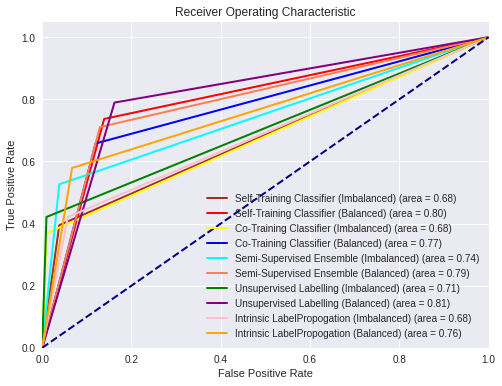

In [ ]:
fpr_st_90_imb, tpr_st_90_imb, auc_st_90_imb = st_90_imb_roc
fpr_st_90_bal, tpr_st_90_bal, auc_st_90_bal = st_90_bal_roc
fpr_ct_90_imb, tpr_ct_90_imb, auc_ct_90_imb = ct_90_imb_roc
fpr_ct_90_bal, tpr_ct_90_bal, auc_ct_90_bal = ct_90_bal_roc
fpr_sse_90_imb, tpr_sse_90_imb, auc_sse_90_imb = sse_90_imb_roc
fpr_sse_90_bal, tpr_sse_90_bal, auc_sse_90_bal = sse_90_bal_roc
fpr_usl_90_imb, tpr_usl_90_imb, auc_usl_90_imb = usl_90_imb_roc
fpr_usl_90_bal, tpr_usl_90_bal, auc_usl_90_bal = usl_90_bal_roc


plt.figure()
lw = 2
plt.figure(figsize=(8,6))

plt.plot(fpr_st_90_imb, tpr_st_90_imb, color='brown',
         lw=lw, label='Self-Training Classifier (Imbalanced) (area = %0.2f)' % auc_st_90_imb)
plt.plot(fpr_st_90_bal, tpr_st_90_bal, color='red',
         lw=lw, label='Self-Training Classifier (Balanced) (area = %0.2f)' % auc_st_90_bal)
plt.plot(fpr_ct_90_imb, tpr_ct_90_imb, color='yellow',
         lw=lw, label='Co-Training Classifier (Imbalanced) (area = %0.2f)' % auc_ct_90_imb)
plt.plot(fpr_ct_90_bal, tpr_ct_90_bal, color='blue',
         lw=lw, label='Co-Training Classifier (Balanced) (area = %0.2f)' % auc_ct_90_bal)
plt.plot(fpr_sse_90_imb, tpr_sse_90_imb, color='aqua',
         lw=lw, label='Semi-Supervised Ensemble (Imbalanced) (area = %0.2f)' % auc_sse_90_imb)
plt.plot(fpr_sse_90_bal, tpr_sse_90_bal, color='coral',
         lw=lw, label='Semi-Supervised Ensemble (Balanced) (area = %0.2f)' % auc_sse_90_bal)
plt.plot(fpr_usl_90_imb, tpr_usl_90_imb, color='green',
         lw=lw, label='Unsupervised Labelling (Imbalanced) (area = %0.2f)' % auc_usl_90_imb)
plt.plot(fpr_usl_90_bal, tpr_usl_90_bal, color='purple',
         lw=lw, label='Unsupervised Labelling (Balanced) (area = %0.2f)' % auc_usl_90_bal)
plt.plot(fpr_int_90_imb, tpr_int_90_imb, color='pink',
         lw=lw, label='Intrinsic LabelSpreading (Imbalanced) (area = %0.2f)' % auc_int_90_imb)
plt.plot(fpr_int_90_bal, tpr_int_90_bal, color='orange',
         lw=lw, label='Intrinsic LabelSpreading (Balanced) (area = %0.2f)' % auc_int_90_bal)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 6. 95% Unlabeled Data

<Figure size 432x288 with 0 Axes>

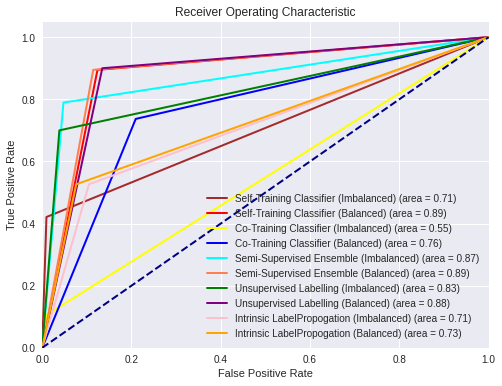

In [ ]:
fpr_st_95_imb, tpr_st_95_imb, auc_st_95_imb = st_95_imb_roc
fpr_st_95_bal, tpr_st_95_bal, auc_st_95_bal = st_95_bal_roc
fpr_ct_95_imb, tpr_ct_95_imb, auc_ct_95_imb = ct_95_imb_roc
fpr_ct_95_bal, tpr_ct_95_bal, auc_ct_95_bal = ct_95_bal_roc
fpr_sse_95_imb, tpr_sse_95_imb, auc_sse_95_imb = sse_95_imb_roc
fpr_sse_95_bal, tpr_sse_95_bal, auc_sse_95_bal = sse_95_bal_roc
fpr_usl_95_imb, tpr_usl_95_imb, auc_usl_95_imb = usl_95_imb_roc
fpr_usl_95_bal, tpr_usl_95_bal, auc_usl_95_bal = usl_95_bal_roc

plt.figure()
lw = 2
plt.figure(figsize=(8,6))

plt.plot(fpr_st_95_imb, tpr_st_95_imb, color='brown',
         lw=lw, label='Self-Training Classifier (Imbalanced) (area = %0.2f)' % auc_st_95_imb)
plt.plot(fpr_st_95_bal, tpr_st_95_bal, color='red',
         lw=lw, label='Self-Training Classifier (Balanced) (area = %0.2f)' % auc_st_95_bal)
plt.plot(fpr_ct_95_imb, tpr_ct_95_imb, color='yellow',
         lw=lw, label='Co-Training Classifier (Imbalanced) (area = %0.2f)' % auc_ct_95_imb)
plt.plot(fpr_ct_95_bal, tpr_ct_95_bal, color='blue',
         lw=lw, label='Co-Training Classifier (Balanced) (area = %0.2f)' % auc_ct_95_bal)
plt.plot(fpr_sse_95_imb, tpr_sse_95_imb, color='aqua',
         lw=lw, label='Semi-Supervised Ensemble (Imbalanced) (area = %0.2f)' % auc_sse_95_imb)
plt.plot(fpr_sse_95_bal, tpr_sse_95_bal, color='coral',
         lw=lw, label='Semi-Supervised Ensemble (Balanced) (area = %0.2f)' % auc_sse_95_bal)
plt.plot(fpr_usl_95_imb, tpr_usl_95_imb, color='green',
         lw=lw, label='Unsupervised Labelling (Imbalanced) (area = %0.2f)' % auc_usl_95_imb)
plt.plot(fpr_usl_95_bal, tpr_usl_95_bal, color='purple',
         lw=lw, label='Unsupervised Labelling (Balanced) (area = %0.2f)' % auc_usl_95_bal)
plt.plot(fpr_int_95_imb, tpr_int_95_imb, color='pink',
         lw=lw, label='Intrinsic LabelSpreading (Imbalanced) (area = %0.2f)' % auc_int_95_imb)
plt.plot(fpr_int_95_bal, tpr_int_95_bal, color='orange',
         lw=lw, label='Intrinsic LabelSpreading (Balanced) (area = %0.2f)' % auc_int_95_bal)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()